# Semi-supervised surgery pipeline with SCANVI

In [1]:
import os
import gdown

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import scanpy as sc
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity

2024-08-20 03:48:36.173444: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 03:48:36.173497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 03:48:36.174700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 03:48:37.384845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
 captum (see https://github.com/pytorch/captum).


In [2]:
def plot_training_history(history, keys):
    """
    Plots the training history for the specified keys in a grid layout.
    
    Parameters:
    - history: dict, containing the training history.
    - keys: list of str, the keys to plot from the history.
    """
    num_plots = len(keys)
    grid_size = int(np.ceil(np.sqrt(num_plots)))

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.flatten()

    for idx, key in enumerate(keys):
        if key in history:
            axes[idx].plot(history[key])
            axes[idx].set_title(key)
        else:
            axes[idx].set_title(f"{key} not found")
        axes[idx].grid(True)

    for idx in range(num_plots, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

In [4]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_float32_matmul_precision("high")
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### IMPORTANT THIS IS WHERE WE CHOOSE THE CELL TYPE LABEL TO TRAIN ON

In [5]:
condition_key = 'dataset'
cell_type_key = 'cell_type_tumor'

## Set relevant anndata.obs labels and training length

In [6]:
adata = sc.read_h5ad('/root/datos/maestria/netopaas/luca/data/atlas/extended.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 1283972 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'is_highly_v

In [8]:
adata = adata[(adata.obs.origin == 'tumor_primary')]


# stages = ['III','III or IV', 'IV']
stages = ['I','II','III','III or IV', 'IV']
adata = adata[adata.obs.uicc_stage.isin(stages)]

# we remove these because some are enriched for endotheliar and some for immune cells
studies = ['Goveia_Carmeliet_2020','Leader_Merad_2021','Guo_Zhang_2018']
adata = adata[~adata.obs.study.isin(studies)]

adata = adata[:, adata.var.is_highly_variable == 'True']


In [9]:
adata

View of AnnData object with n_obs × n_vars = 402634 × 5989
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'is_hi

In [10]:
import gc
del adata.raw
gc.collect()

del adata.layers['counts_length_scaled']
adata.X = adata.layers['count'].copy()

In [11]:
# adata = remove_sparsity(adata)
source_adata = adata

## Create SCANVI model and train it on fully labelled reference dataset

In [11]:

sca.models.SCVI.setup_anndata(source_adata, labels_key=cell_type_key,
                             batch_key=condition_key # HCLA atlas did not correct for sample,
                              # as they wanted to maintain variability
                             )

In [12]:
source_adata.obs

sample uicc_stage ever_smoker  \
AAACCCAAGAGCCATG-1_0-1    Chen_Zhang_2020_NSCLC-10        III         NaN   
AAACCCAAGATTAGAC-1_0-1    Chen_Zhang_2020_NSCLC-10        III         NaN   
AAACCCAAGGTCGCCT-1_0-1    Chen_Zhang_2020_NSCLC-10        III         NaN   
AAACCCAAGTCATTGC-1_0-1    Chen_Zhang_2020_NSCLC-10        III         NaN   
AAACCCACACGGATCC-1_0-1    Chen_Zhang_2020_NSCLC-10        III         NaN   
...                                            ...        ...         ...   
811511_27-3             UKIM-V-2_P17_tumor_primary          I         yes   
468397_27-3             UKIM-V-2_P17_tumor_primary          I         yes   
115884_27-3             UKIM-V-2_P17_tumor_primary          I         yes   
201201_27-3             UKIM-V-2_P17_tumor_primary          I         yes   
194204_27-3             UKIM-V-2_P17_tumor_primary          I         yes   

                         age                  donor_id         origin  \
AAACCCAAGAGCCATG-1_0-1   NaN  Chen_Zhang_2020_NSCLC-10  tumor_primary   
AAACCCAAGATTAGAC-1_0-1   NaN  Chen_Zhang_2020_NSCLC-10  tumor_primary   
AAACCCAAGGTCGCCT-1_0-1   NaN  Chen_Zhang_2020_NSCLC-10  tumor_primary   
AAACCCAAGTCATTGC-1_0-1   NaN  Chen_Zhang_2020_NSCLC-10  tumor_primary   
AAACCCACACGGATCC-1_0-1   NaN  Chen_Zhang_2020_NSCLC-10  tumor_primary   
...                      ...                       ...            ...   
811511_27-3             60.0              UKIM-V-2_P17  tumor_primary   
468397_27-3             60.0              UKIM-V-2_P17  tumor_primary   
115884_27-3             60.0              UKIM-V-2_P17  tumor_primary   
201201_27-3             60.0              UKIM-V-2_P17  tumor_primary   
194204_27-3             60.0              UKIM-V-2_P17  tumor_primary   

                                dataset                    ann_fine  \
AAACCCAAGAGCCATG-1_0-1  Chen_Zhang_2020  T cell CD8 effector memory   
AAACCCAAGATTAGAC-1_0-1  Chen_Zhang_2020                Cancer cells   
AAACCCAAGGTCGCCT-1_0-1  Chen_Zhang_2020                      B cell   
AAACCCAAGTCATTGC-1_0-1  Chen_Zhang_2020                      B cell   
AAACCCACACGGATCC-1_0-1  Chen_Zhang_2020                 Plasma cell   
...                                 ...                         ...   
811511_27-3                    UKIM-V-2                 Neutrophils   
468397_27-3                    UKIM-V-2                 Neutrophils   
115884_27-3                    UKIM-V-2                 Neutrophils   
201201_27-3                    UKIM-V-2                 Neutrophils   
194204_27-3                    UKIM-V-2                 Neutrophils   

                              cell_type_predicted doublet_status  ...  \
AAACCCAAGAGCCATG-1_0-1                 T cell CD8        singlet  ...   
AAACCCAAGATTAGAC-1_0-1  Epithelial cell malignant        singlet  ...   
AAACCCAAGGTCGCCT-1_0-1                     B cell        singlet  ...   
AAACCCAAGTCATTGC-1_0-1                     B cell        singlet  ...   
AAACCCACACGGATCC-1_0-1                Plasma cell        singlet  ...   
...                                           ...            ...  ...   
811511_27-3                                   NaN        singlet  ...   
468397_27-3                                   NaN        singlet  ...   
115884_27-3                                   NaN        singlet  ...   
201201_27-3                                   NaN        singlet  ...   
194204_27-3                                   NaN        singlet  ...   

                                                           assay  \
AAACCCAAGAGCCATG-1_0-1                                 10x 3' v3   
AAACCCAAGATTAGAC-1_0-1                                 10x 3' v3   
AAACCCAAGGTCGCCT-1_0-1                                 10x 3' v3   
AAACCCAAGTCATTGC-1_0-1                                 10x 3' v3   
AAACCCACACGGATCC-1_0-1                                 10x 3' v3   
...                                                          ...   
811511_27-3             BD Rhapsody 

### b128_lay6_h1024

In [17]:
# elbo_trai is btter for converging and elbo is better for generalization.
# I would suggest, elbo_train for scVi and elbo for scANVI
early_stopping_kwargs = {
    "early_stopping_monitor": "elbo",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.01,
}
# This very importanto for actual covnergence... we have seen we tend to hit local minima and this helps i navoiding but only once...  a peridic approach would ve good
plan_kwargs= {
# "weight_decay": 0.0,
    # "reduce_lr_on_plateau": True,
    # "lr_patience": 8,
    # "lr_factor": 0.1,
}


vae = sca.models.SCVI(
    source_adata,
    n_layers=6,
    n_latent=20,
    n_hidden=1024,
    encode_covariates=True,
    deeply_inject_covariates=False,
    gene_likelihood='nb',  # Nb maybe may have less false postiives, because zinb zeros are complete technical zeroes which are not very realistic
    use_layer_norm="both",
    use_batch_norm="none",
)

In [18]:
# this levaes with litlle epochs and that does not achieve good accuracy
# max_epochs_scvi = np.min([round((20000 / source_adata.n_obs) * 400), 400])
vae.train(max_epochs=400, early_stopping=early_stopping_kwargs, plan_kwargs=plan_kwargs, batch_size=128)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [7:42:37<00:00, 67.61s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.65e+3]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [7:42:37<00:00, 69.39s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.65e+3]


In [19]:
ref_path = '/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_tumor_model_b128_lay6_h1024/'
vae.save(ref_path, overwrite=True)

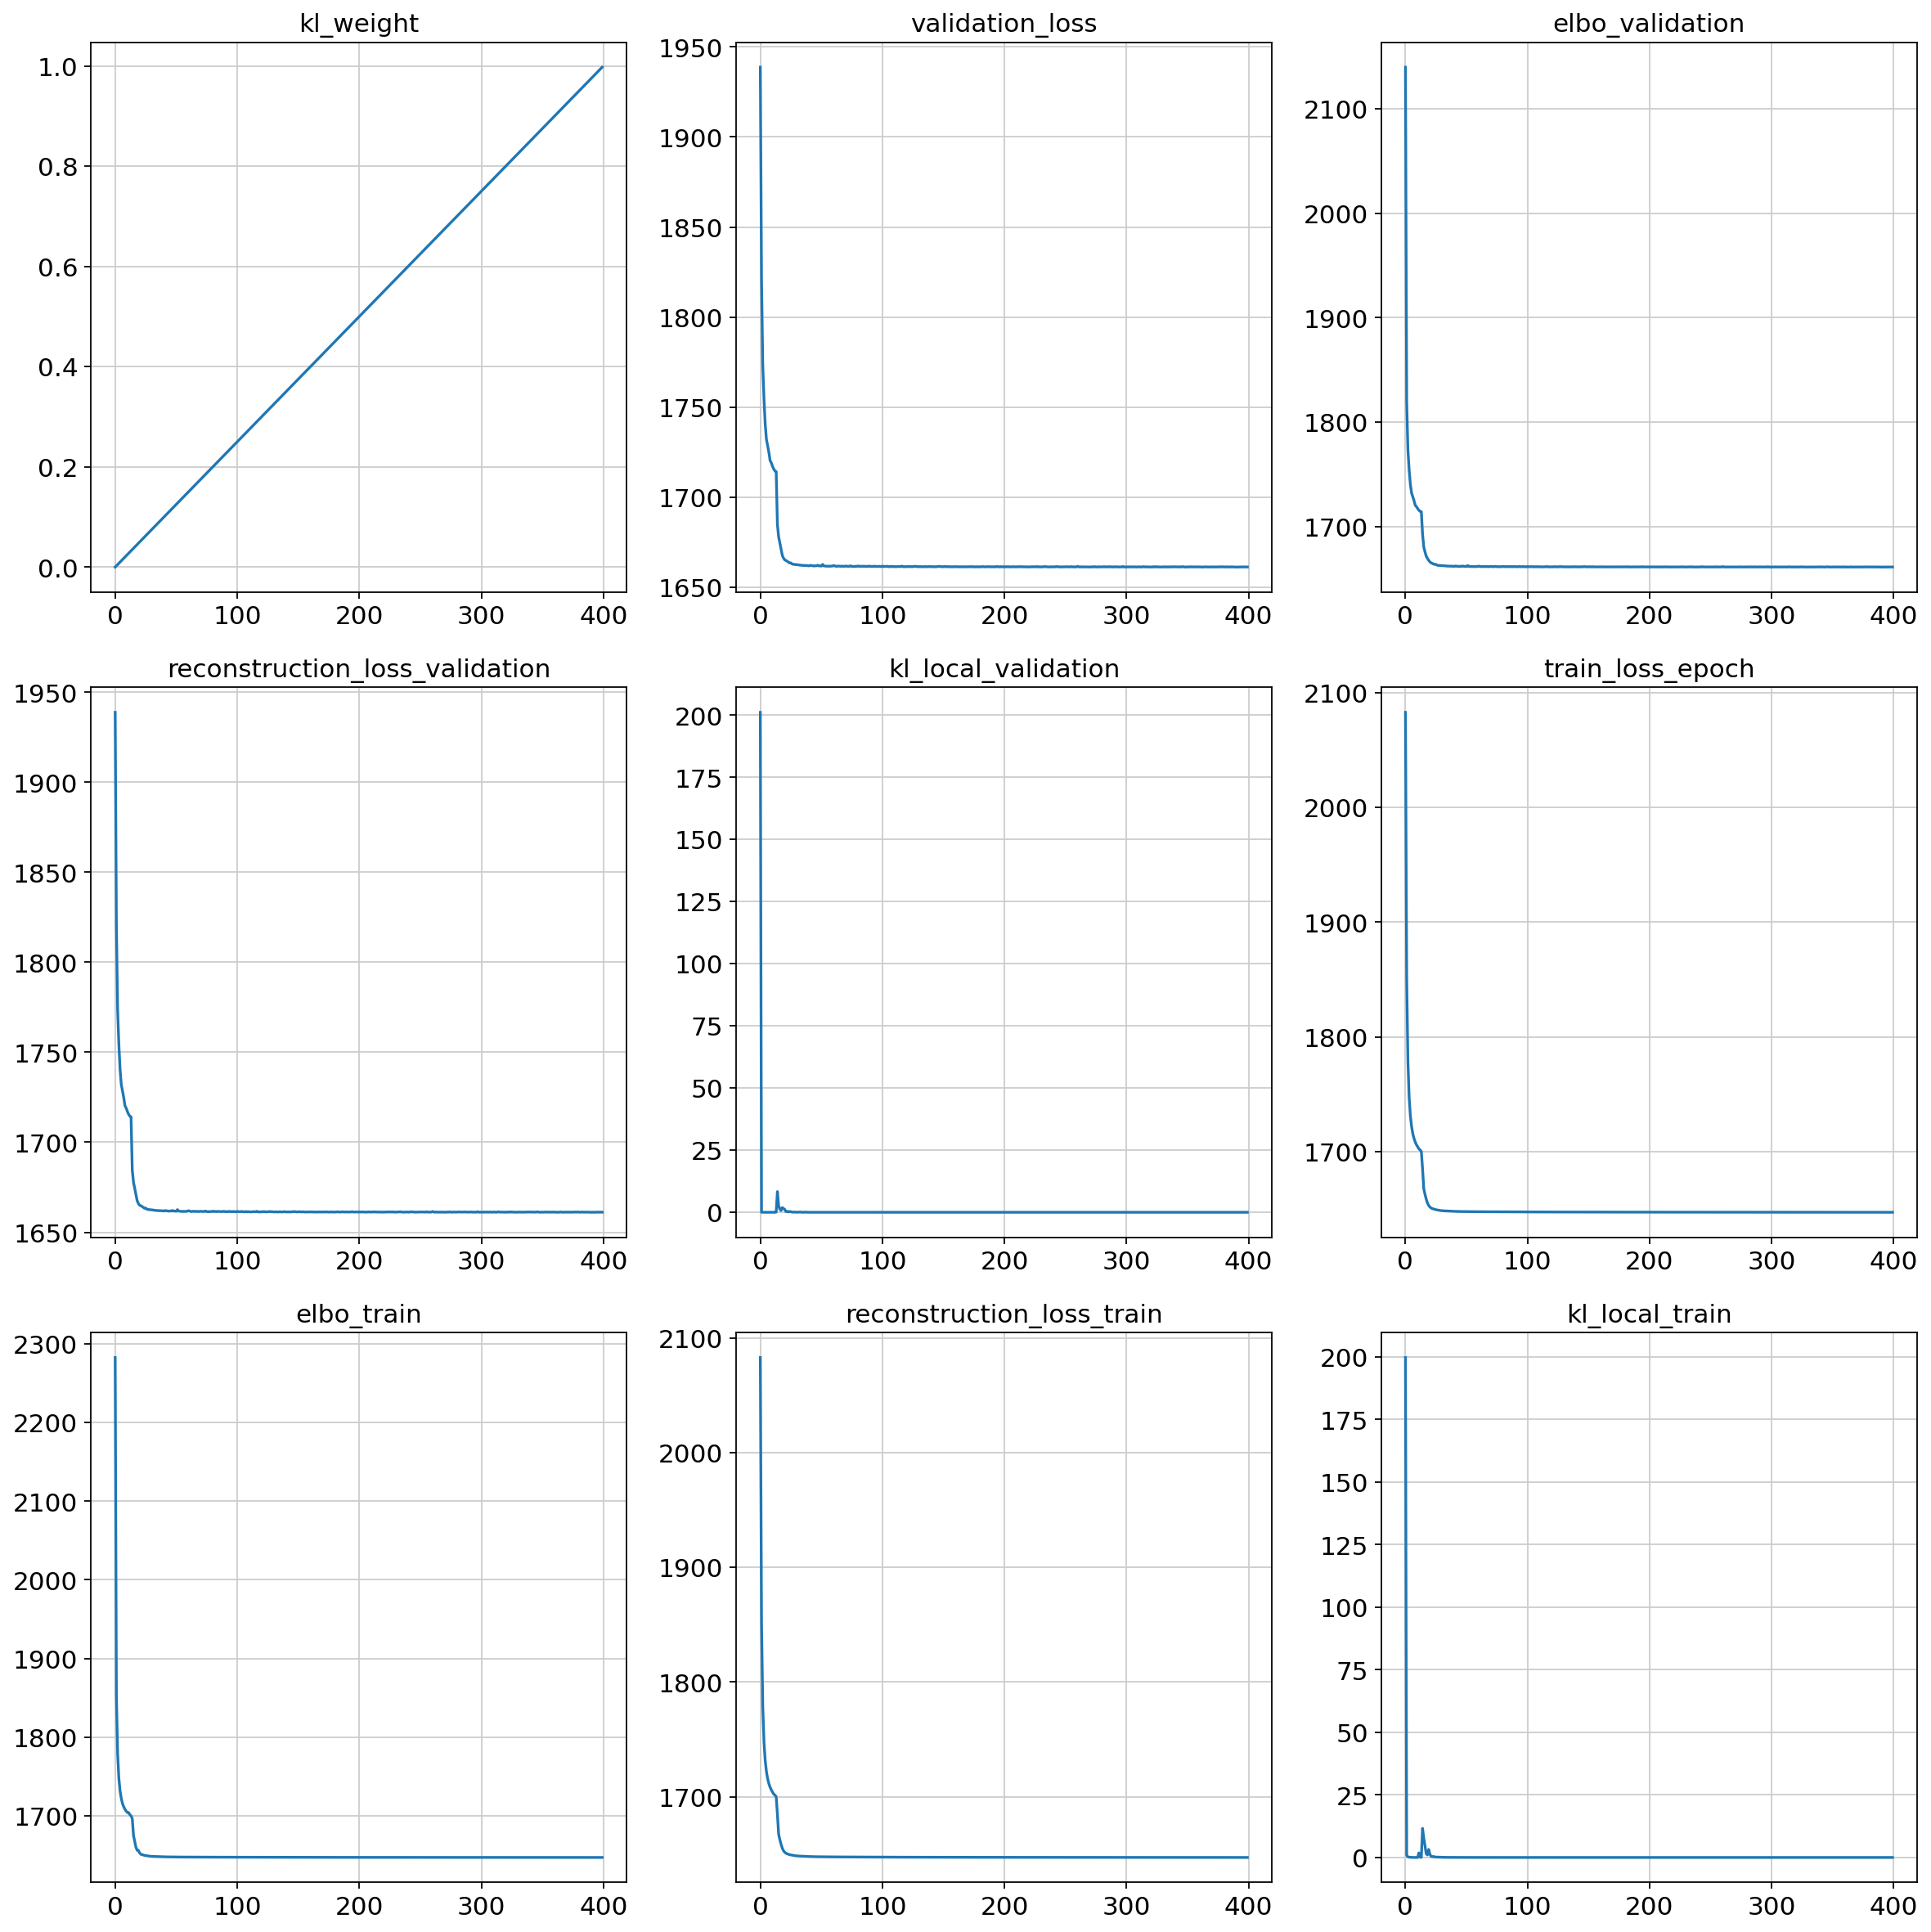

In [20]:
# 128bsize, 400 max, stop 85, 3 layers, 512 hidden
history_keys = [
    'kl_weight', 'validation_loss', 'elbo_validation', 
    'reconstruction_loss_validation', 'kl_local_validation', 
    'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 
    'kl_local_train'
]

# Assuming scanvae.history contains the training history
plot_training_history(vae.history, history_keys)

### b128_lay3_h512

In [16]:
# elbo_trai is btter for converging and elbo is better for generalization.
# I would suggest, elbo_train for scVi and elbo for scANVI
early_stopping_kwargs = {
    "early_stopping_monitor": "elbo",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.01,
}
# This very importanto for actual covnergence... we have seen we tend to hit local minima and this helps i navoiding but only once...  a peridic approach would ve good
plan_kwargs= {"weight_decay": 0.0,
    # "reduce_lr_on_plateau": True,
    # "lr_patience": 8,
    # "lr_factor": 0.1,
}


vae = sca.models.SCVI(
    source_adata,
    n_layers=3,
    n_latent=20,
    n_hidden=512,
    encode_covariates=True,
    deeply_inject_covariates=False,
    gene_likelihood='nb',  # Nb maybe may have less false postiives, because zinb zeros are complete technical zeroes which are not very realistic
    use_layer_norm="both",
    use_batch_norm="none",
)

In [17]:
# this levaes with litlle epochs and that does not achieve good accuracy
# max_epochs_scvi = np.min([round((20000 / source_adata.n_obs) * 400), 400])
vae.train(max_epochs=400, early_stopping=early_stopping_kwargs, plan_kwargs=plan_kwargs, batch_size=128)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 81/400:  20%|███████████████████▏                                                                           | 81/400 [1:06:07<4:20:26, 48.99s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.41e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1483.175. Signaling Trainer to stop.


In [18]:
ref_path = '/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_tumor_model_b128_lay3_h512/'
vae.save(ref_path, overwrite=True)

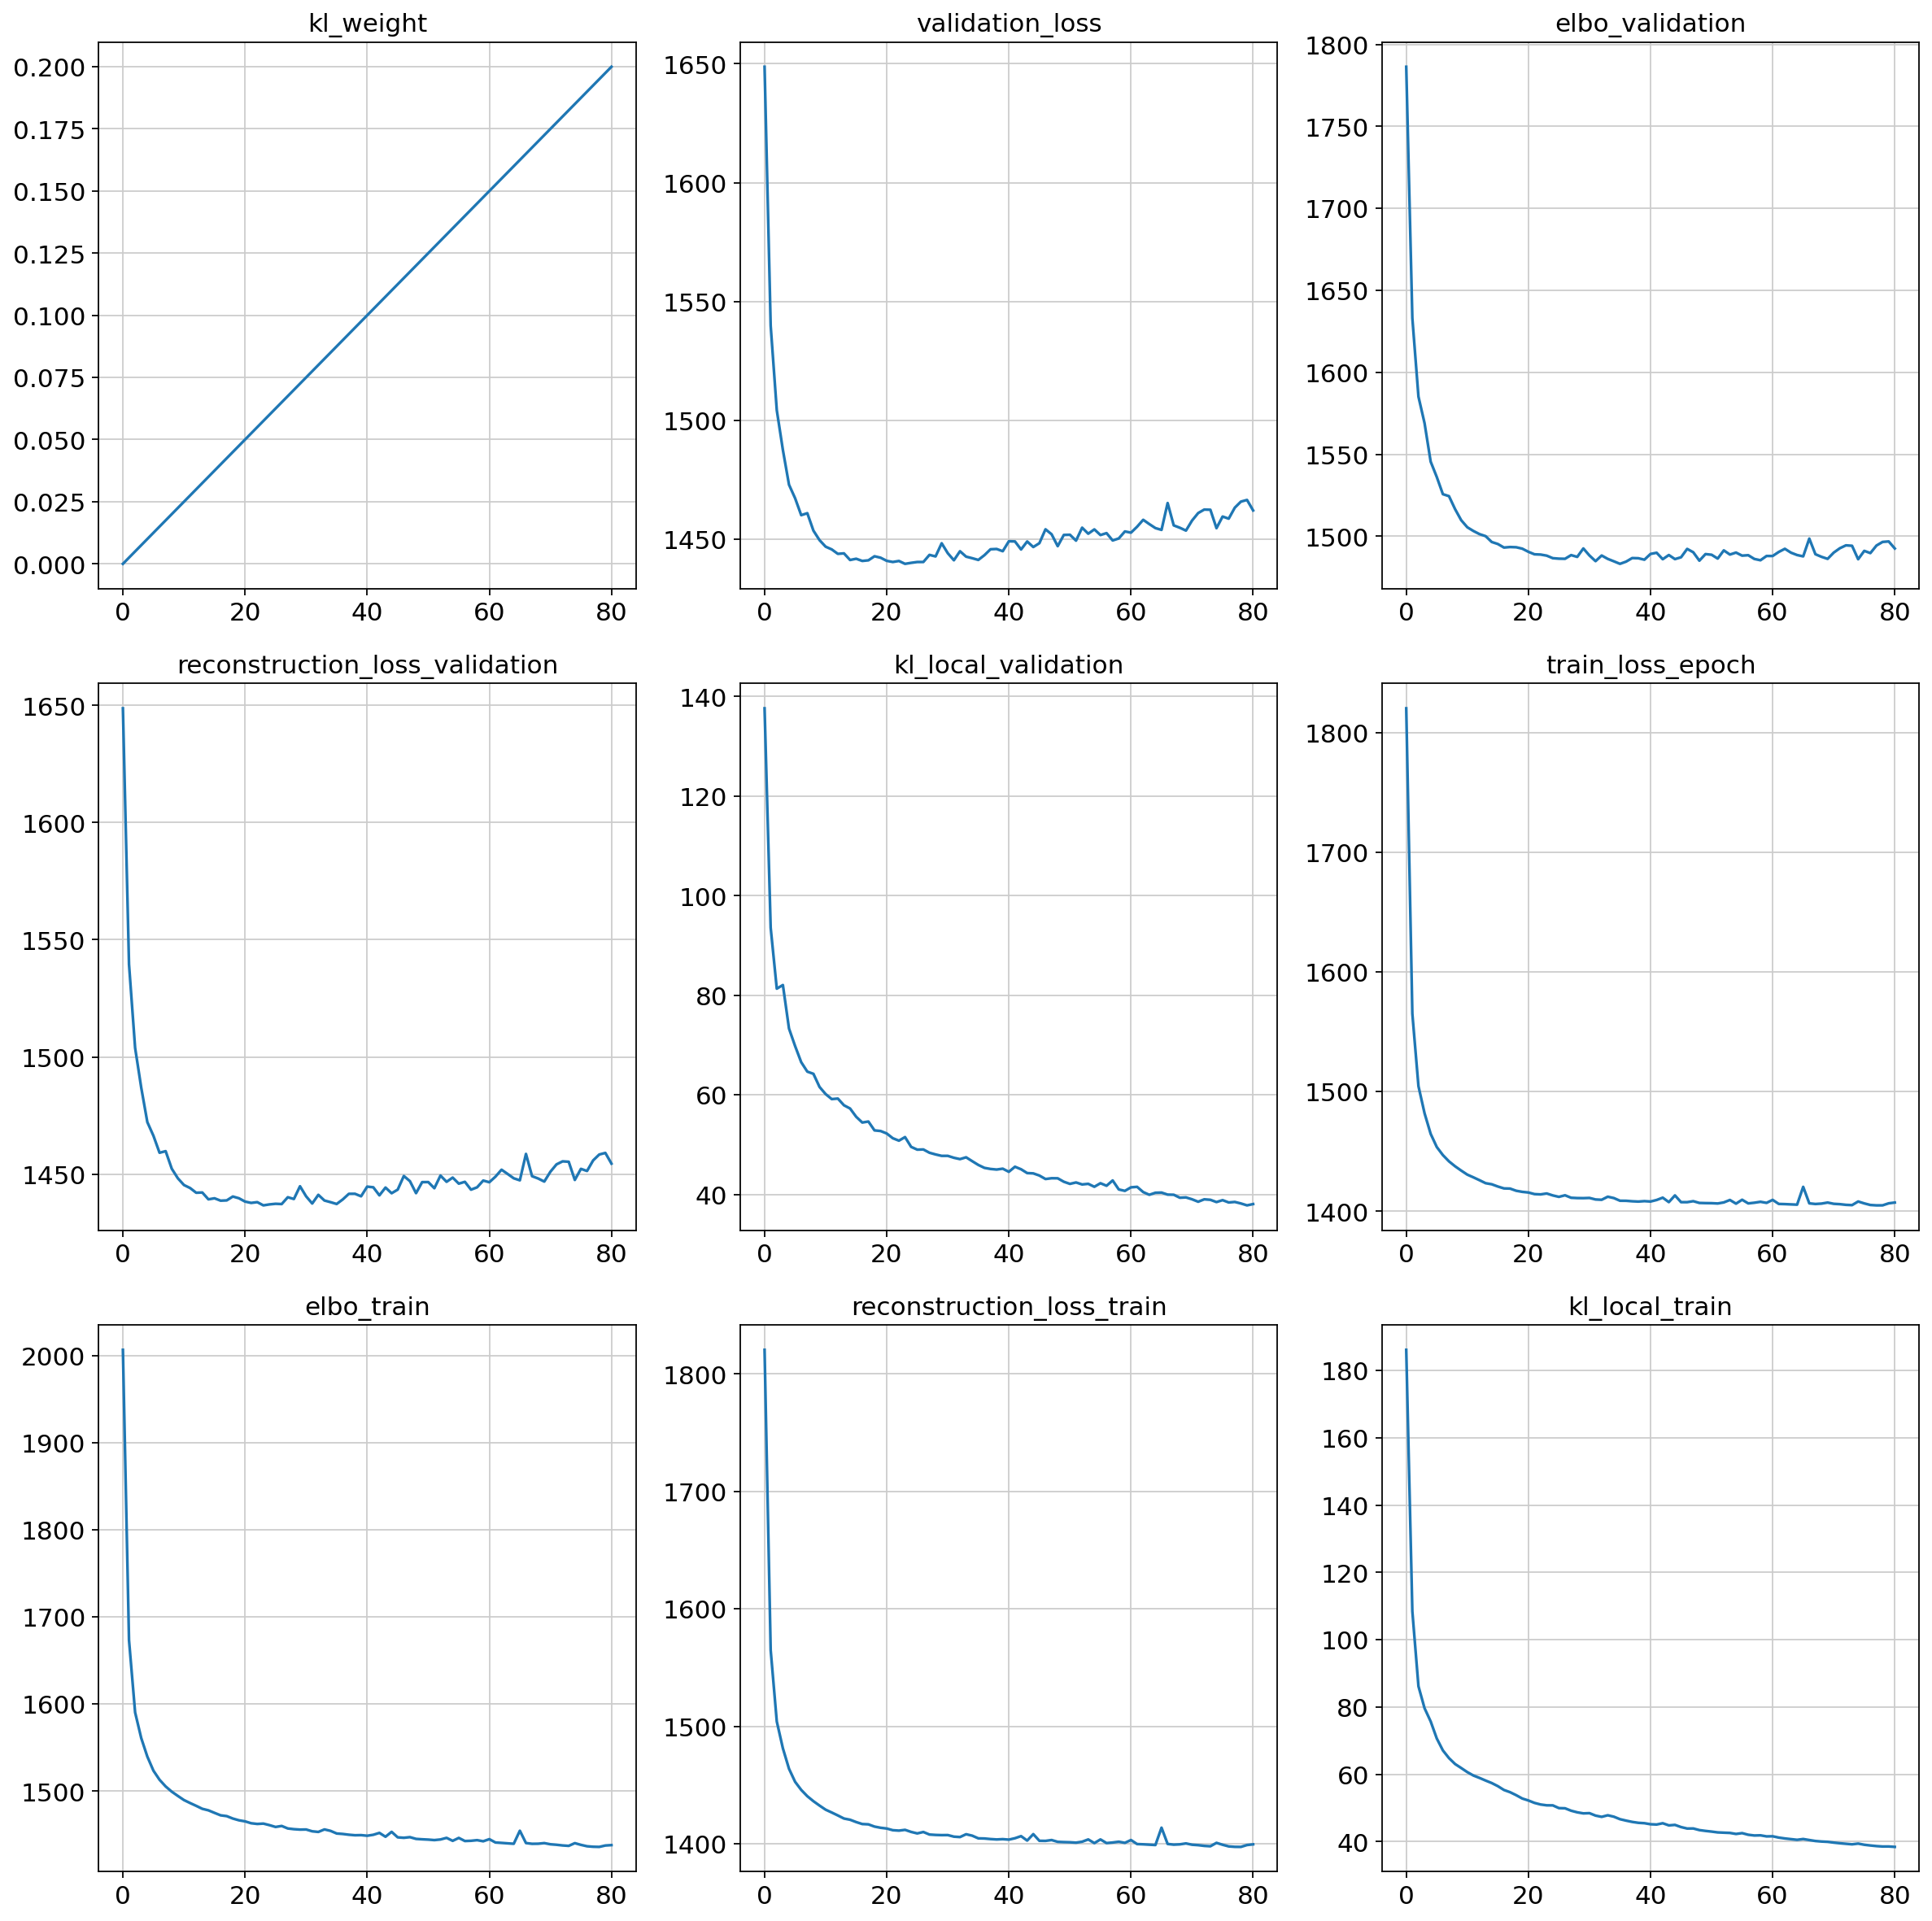

In [28]:
# 128bsize, 400 max, stop 85, 3 layers, 512 hidden
history_keys = [
    'kl_weight', 'validation_loss', 'elbo_validation', 
    'reconstruction_loss_validation', 'kl_local_validation', 
    'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 
    'kl_local_train'
]

# Assuming scanvae.history contains the training history
plot_training_history(vae.history, history_keys)

In [21]:
scanvae = sca.models.SCANVI.from_scvi_model(vae, unlabeled_category = "Unknown")

In [22]:
early_stopping_kwargs = {
    "early_stopping_monitor": "elbo",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.01,
}
# # This very importanto for actual covnergence... we have seen we tend to hit local minima and this helps i navoiding but only once...  a peridic approach would ve good
plan_kwargs= {
    # "weight_decay": 0.0,
#     "reduce_lr_on_plateau": True,
#     "lr_patience": 8,
#     "lr_factor": 0.1,
}


scanvae.train(max_epochs=300, early_stopping=early_stopping_kwargs, plan_kwargs=plan_kwargs, batch_size=128)

INFO     Training for 300 epochs.                                                                                  


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 53/300:  18%|████████████████▊                                                                              | 53/300 [8:53:09<41:24:43, 603.58s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.8e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1657.337. Signaling Trainer to stop.


In [23]:
reference_latent = sc.AnnData(scanvae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = source_adata.obs[condition_key].tolist()

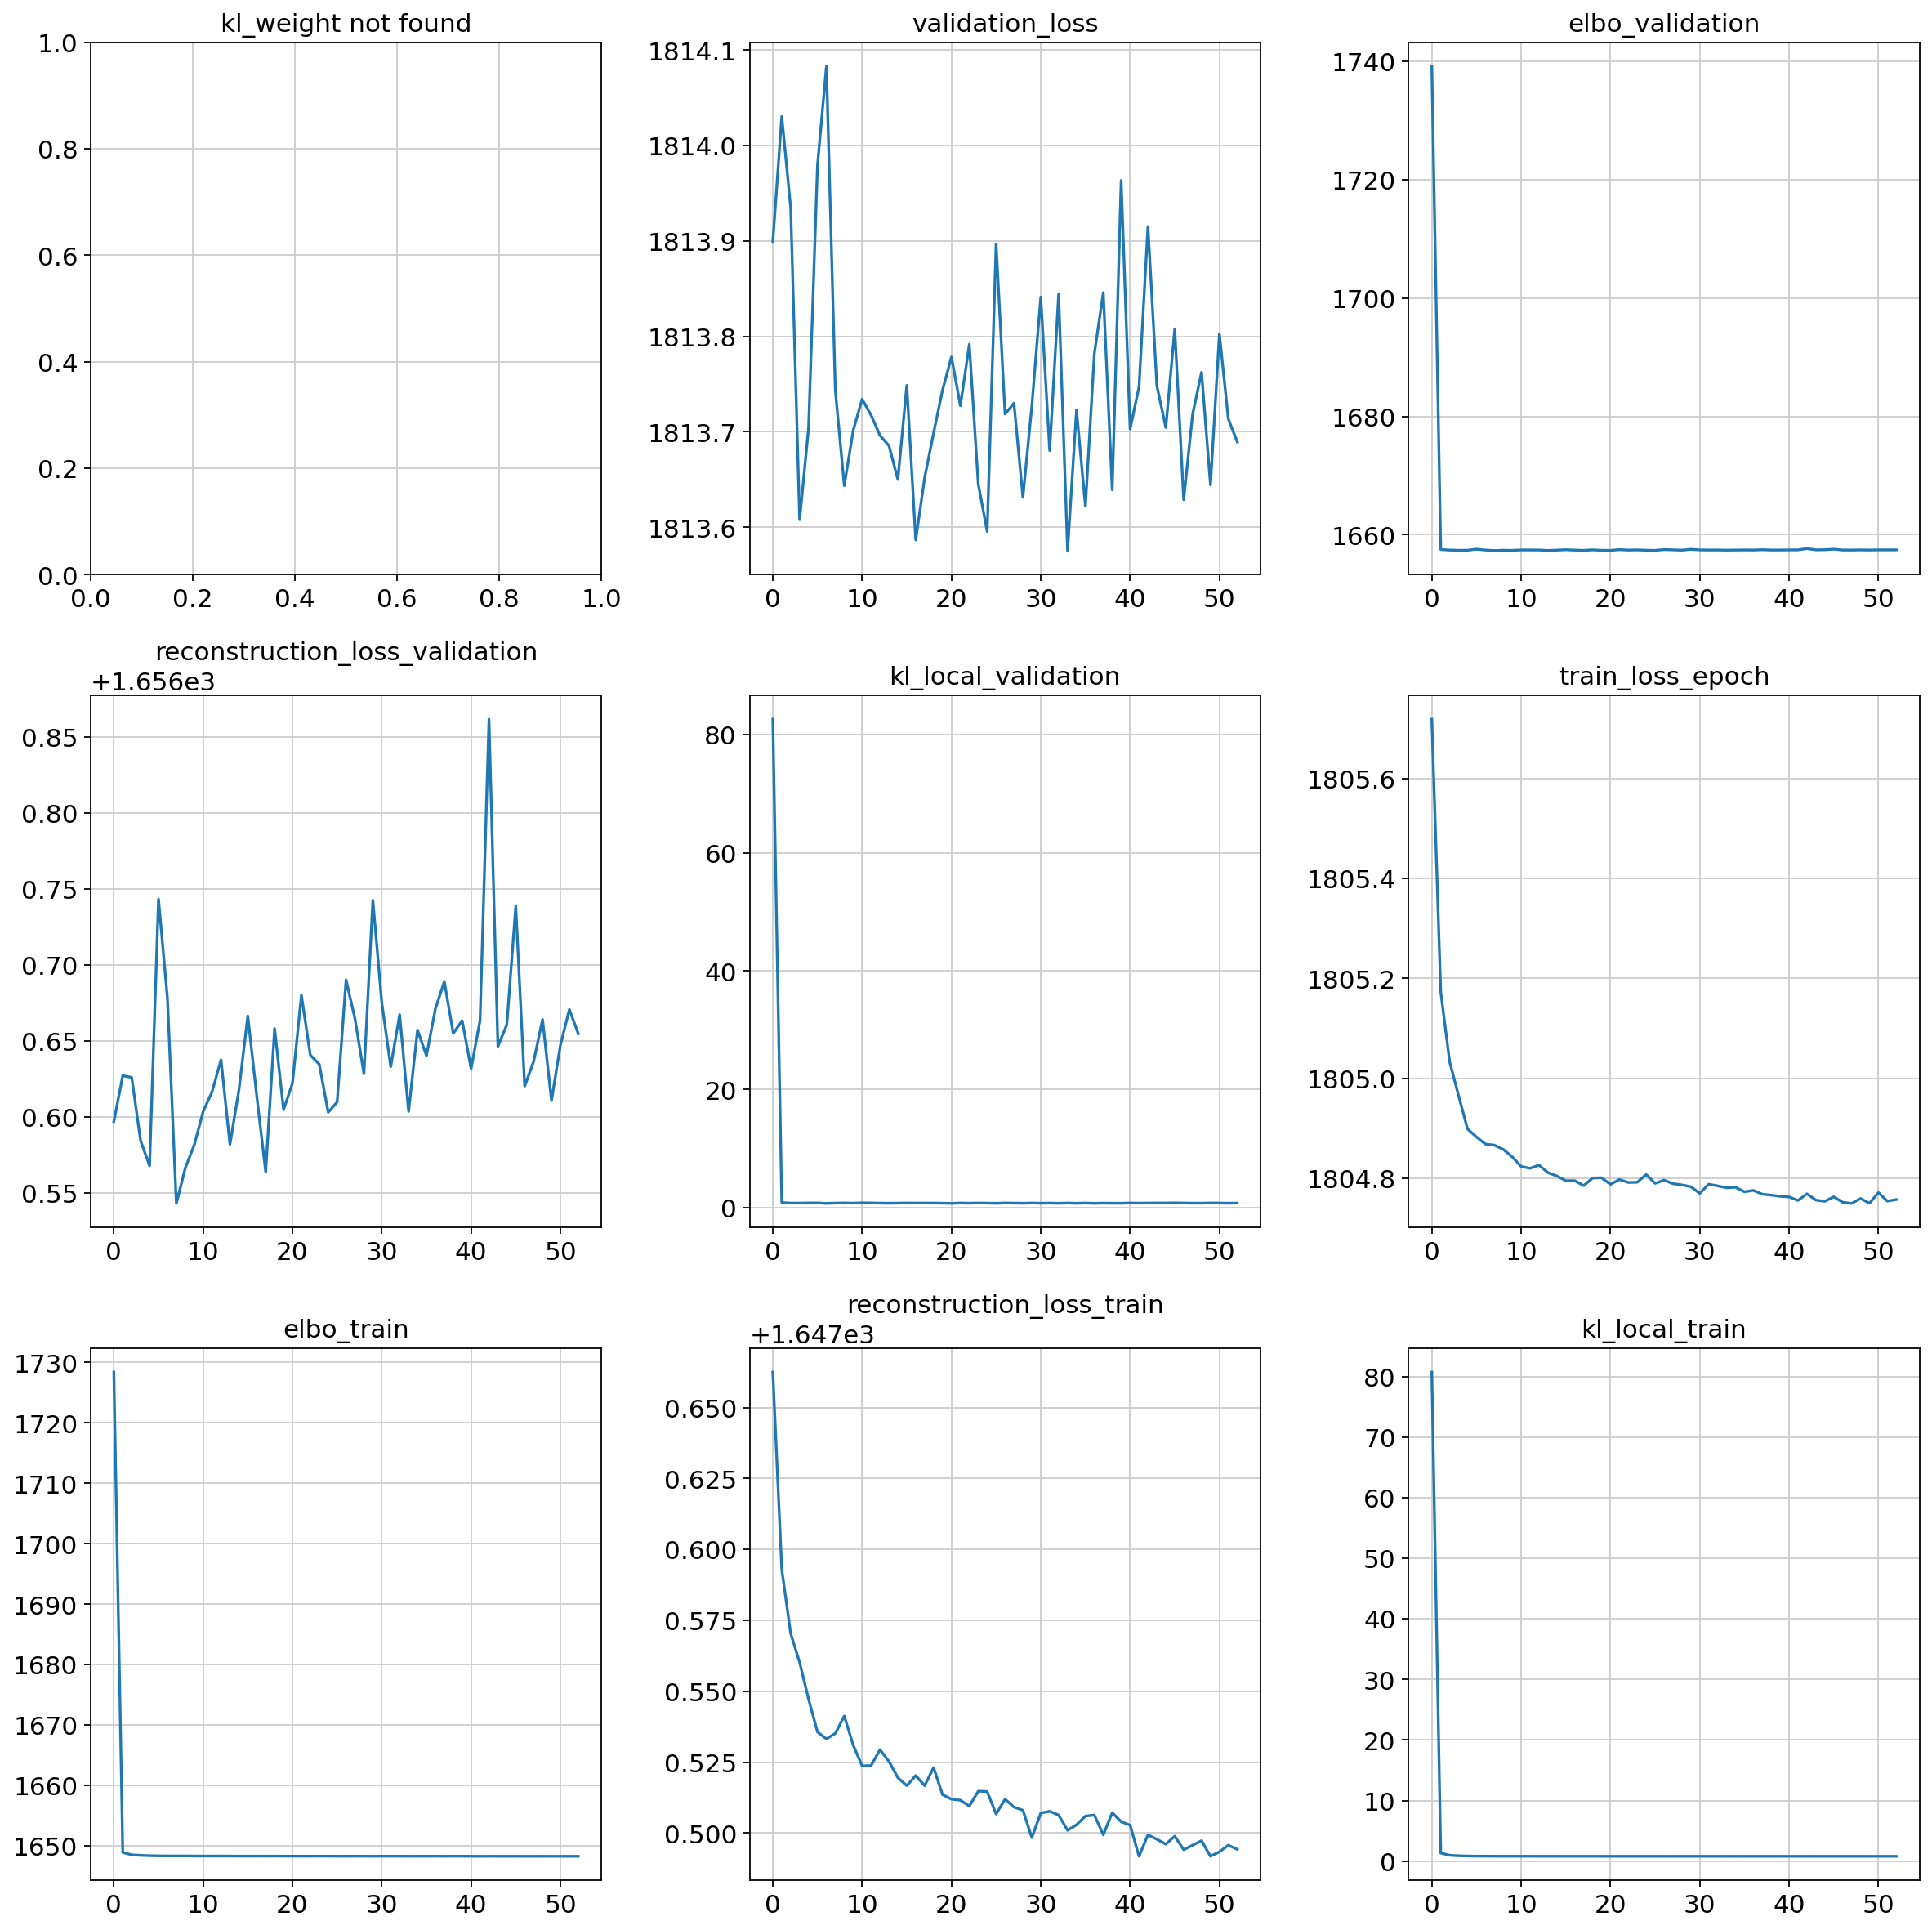

In [25]:
#vae 70 epoch, 128 bsize, hidden512, l 3; scanvae 80 epoch;  
history_keys = [
    'kl_weight', 'validation_loss', 'elbo_validation', 
    'reconstruction_loss_validation', 'kl_local_validation', 
    'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 
    'kl_local_train'
]

# Assuming scanvae.history contains the training history
plot_training_history(scanvae.history, history_keys)

In [24]:

reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.13966778761853196


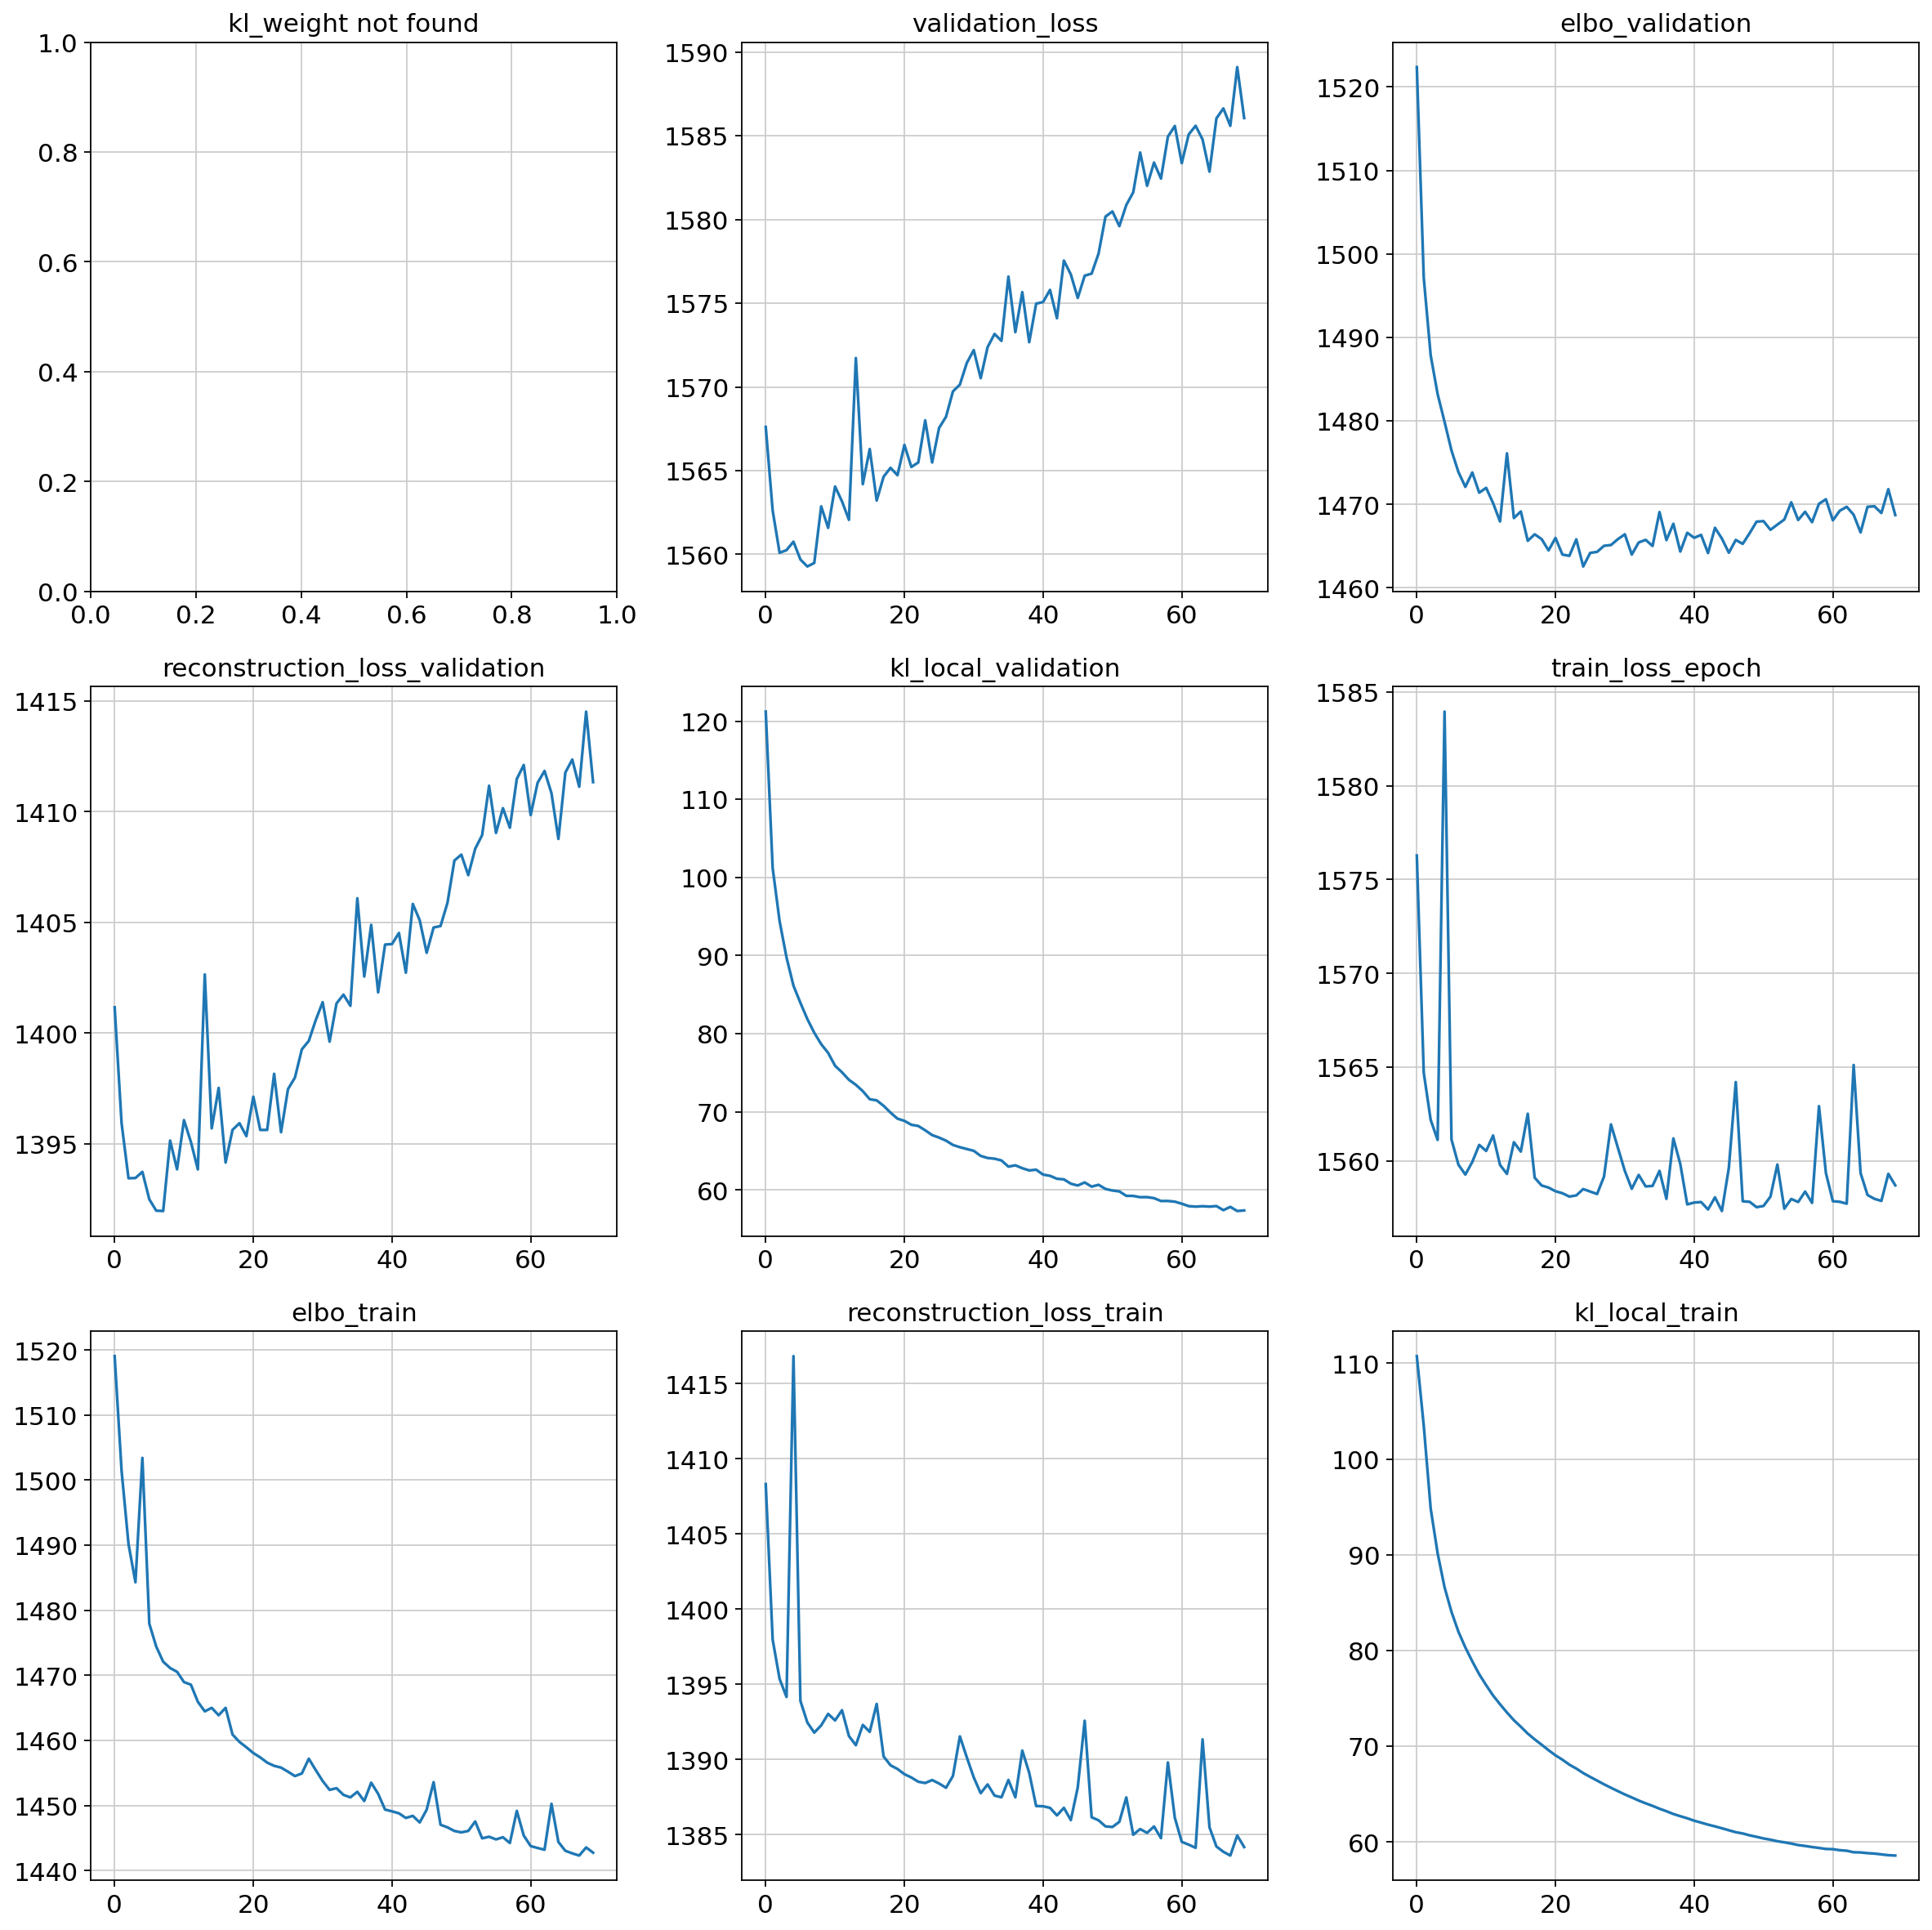

In [35]:
#vae 70 epoch, 128 bsize, hidden512, l 3; scanvae 80 epoch;  weight decay on
history_keys = [
    'kl_weight', 'validation_loss', 'elbo_validation', 
    'reconstruction_loss_validation', 'kl_local_validation', 
    'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 
    'kl_local_train'
]

# Assuming scanvae.history contains the training history
plot_training_history(scanvae.history, history_keys)

In [38]:
#vae 70 epoch, 128 bsize, hidden512, l 3; scanvae 80 epoch;  
reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.6790434985619694


In [68]:
ref_path = '/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_anvi4layers/'
scanvae.save(ref_path, overwrite=True)

### b1024_lay4_h512

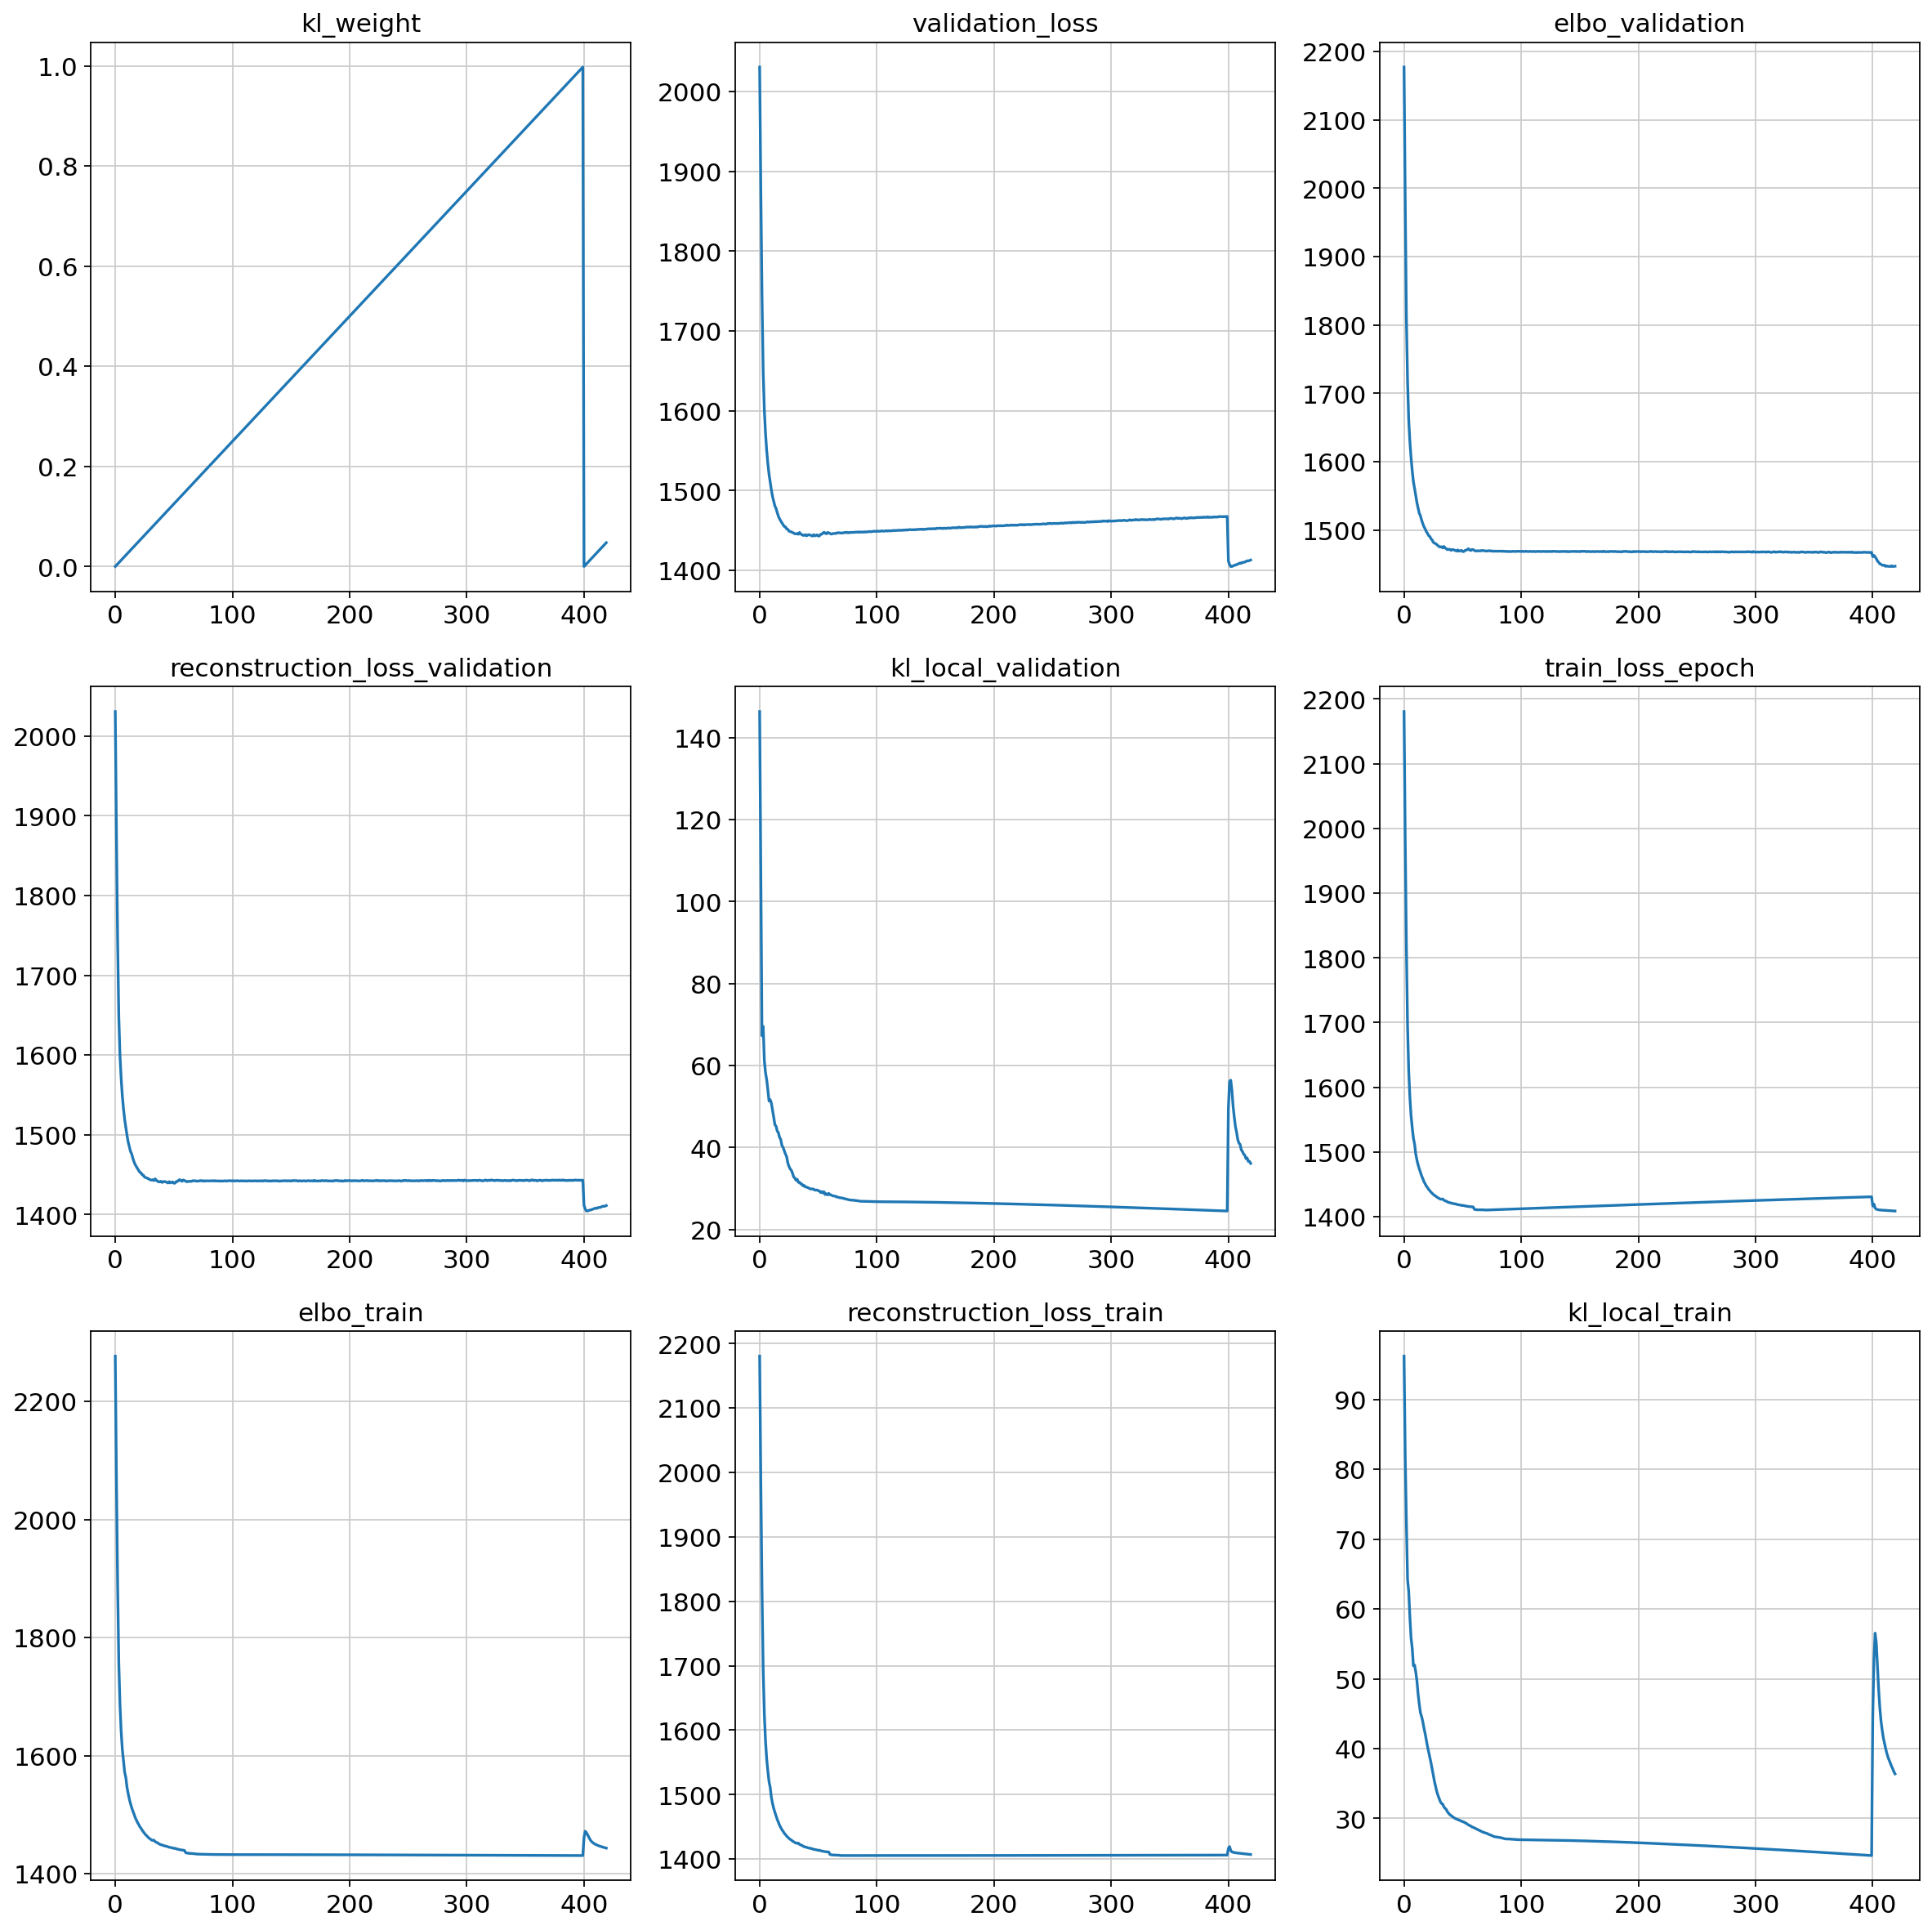

In [76]:
# hidden 512, batch 1024, layers 4, epoch 400 then 20
history_keys = [
    'kl_weight', 'validation_loss', 'elbo_validation', 
    'reconstruction_loss_validation', 'kl_local_validation', 
    'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 
    'kl_local_train'
]

# Assuming scanvae.history contains the training history
plot_training_history(vae.history, history_keys)

In [21]:
scanvae = sca.models.SCANVI.from_scvi_model(vae, unlabeled_category = "Unknown")

In [ ]:
early_stopping_kwargs = {
    "early_stopping_monitor": "elbo",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.01,
}
# # This very importanto for actual covnergence... we have seen we tend to hit local minima and this helps i navoiding but only once...  a peridic approach would ve good
plan_kwargs= {
    # "weight_decay": 0.0,
#     "reduce_lr_on_plateau": True,
#     "lr_patience": 8,
#     "lr_factor": 0.1,
}


scanvae.train(max_epochs=300, early_stopping=early_stopping_kwargs, plan_kwargs=plan_kwargs, batch_size=128)

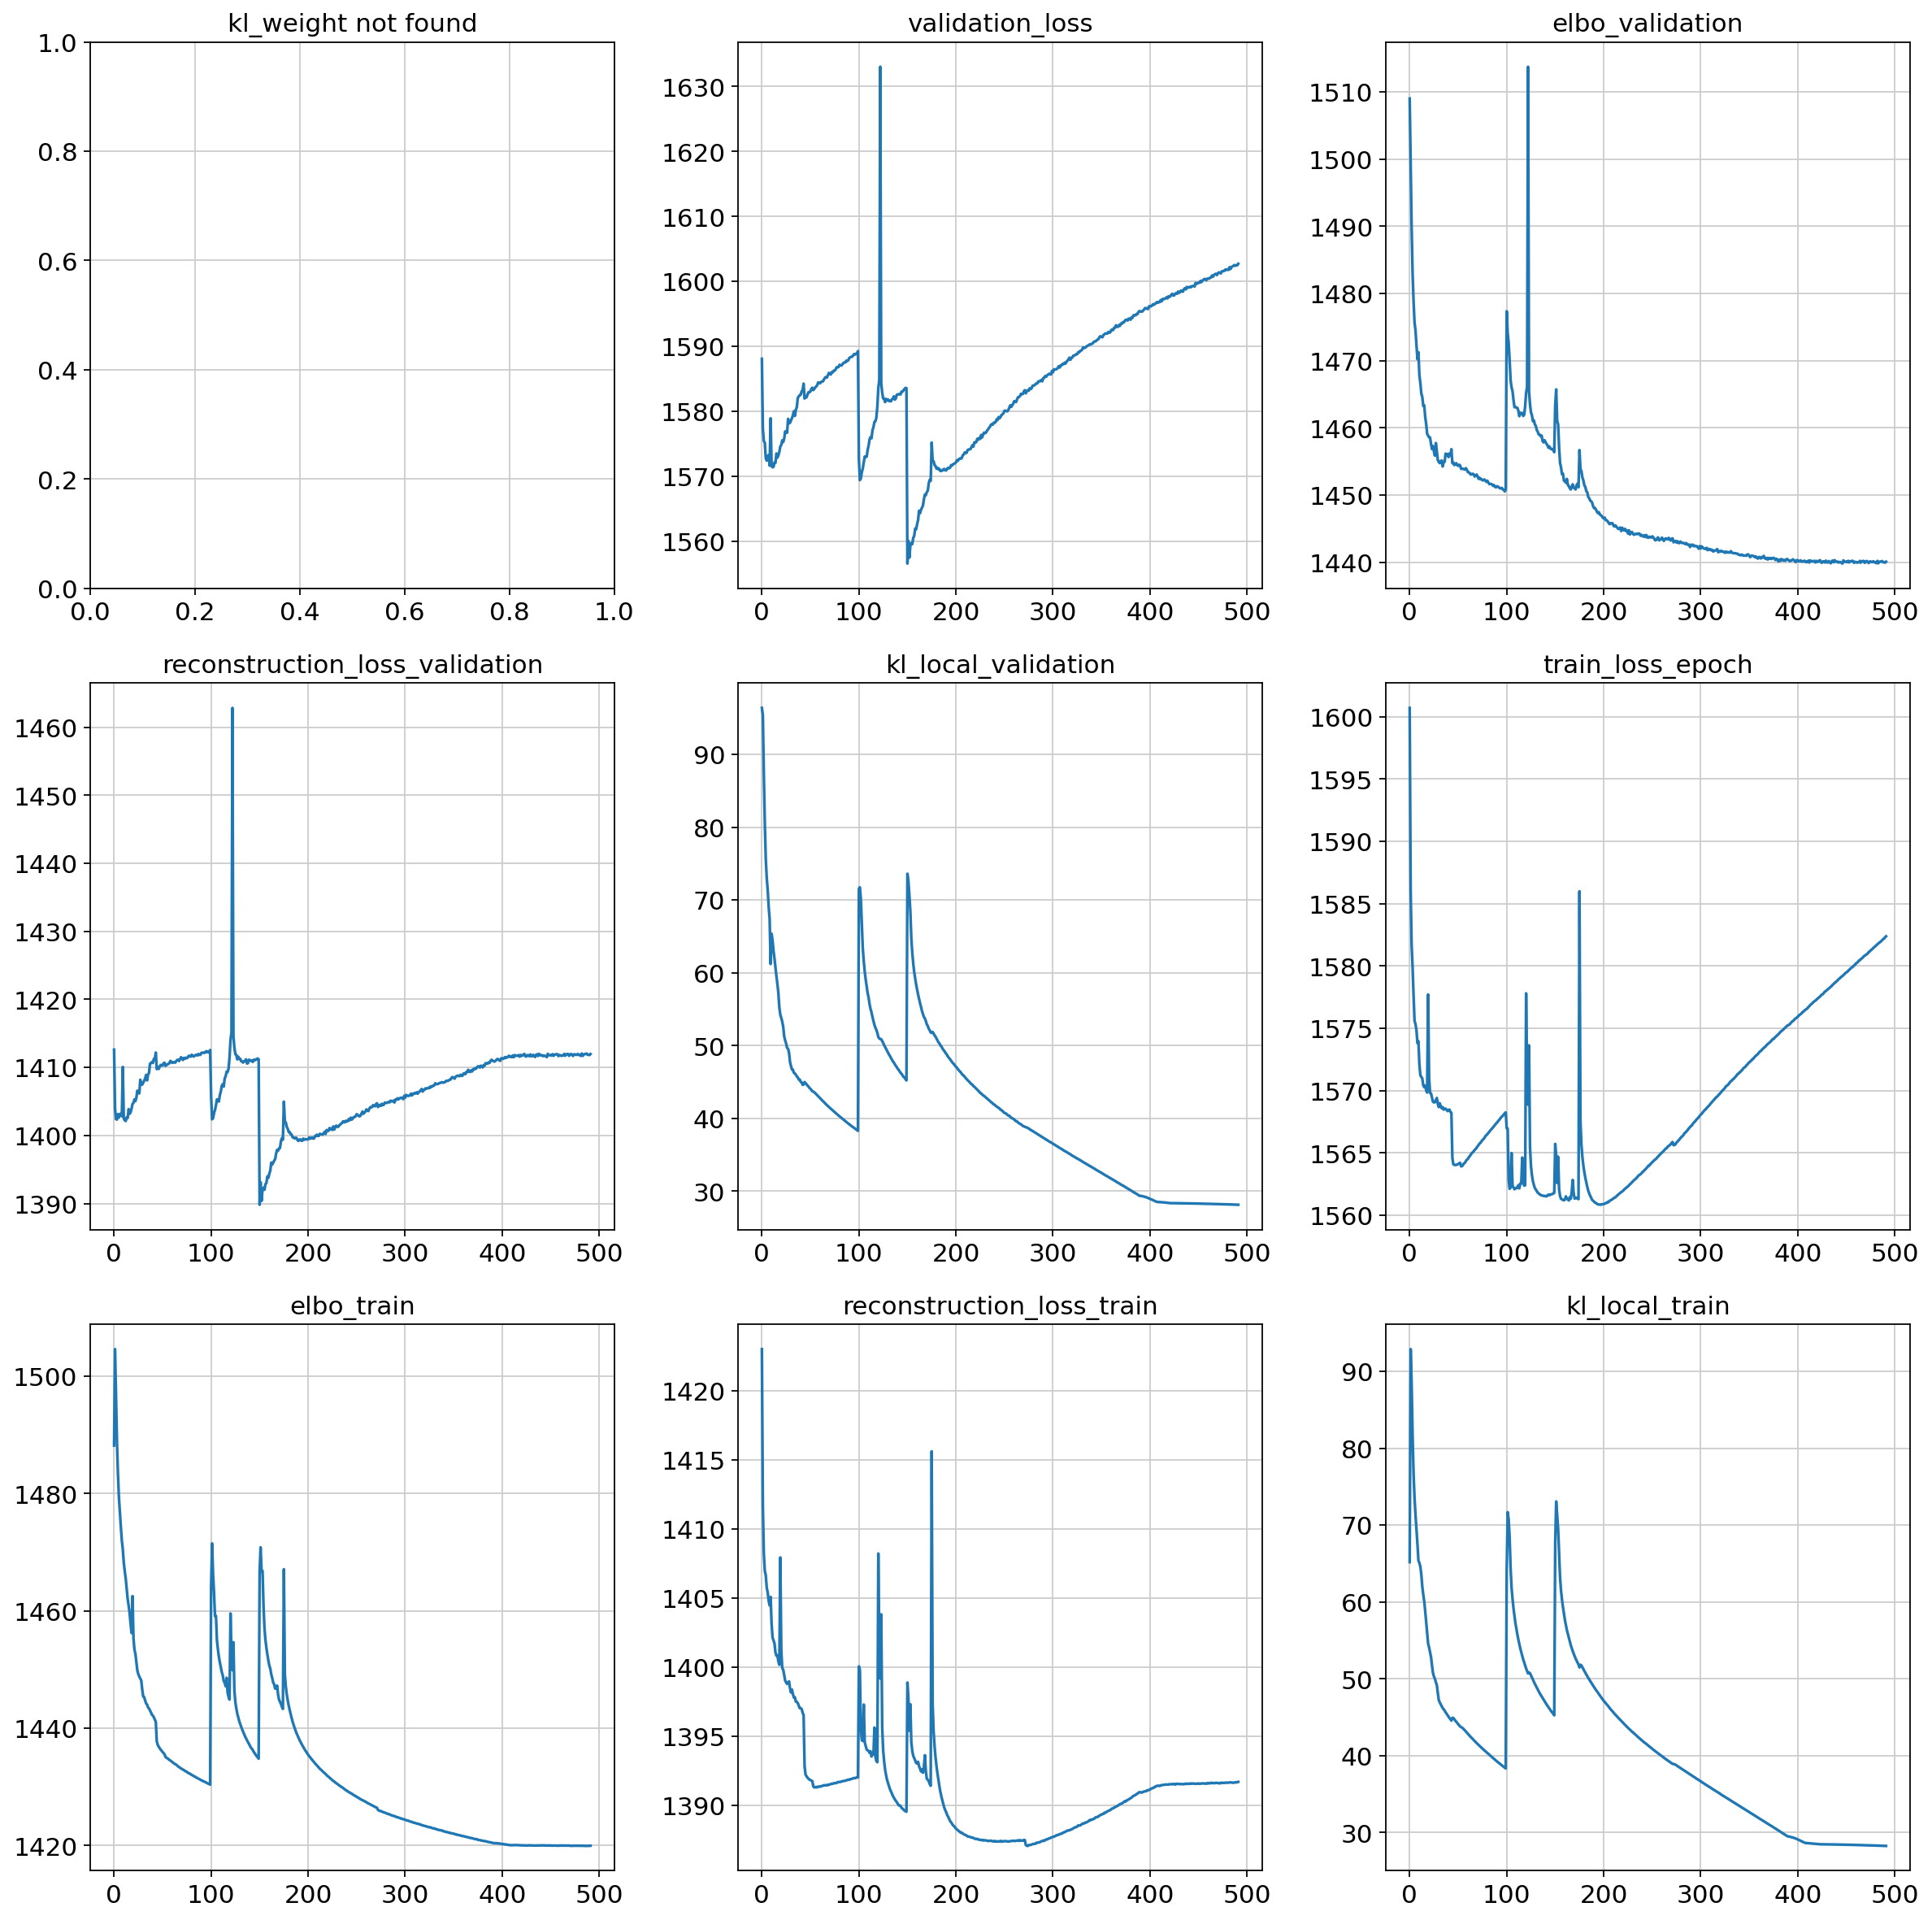

In [80]:
# 1 time vae 100 epoch, 512 bsize, 4 layers; 2 times scanvae 100-400
history_keys = [
    'kl_weight', 'validation_loss', 'elbo_validation', 
    'reconstruction_loss_validation', 'kl_local_validation', 
    'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 
    'kl_local_train'
]

# Assuming scanvae.history contains the training history
plot_training_history(scanvae.history, history_keys)

## Create anndata file of latent representation and compute UMAP

In [37]:
reference_latent = sc.AnnData(scanvae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = source_adata.obs[condition_key].tolist()

In [27]:
reference_latent.write_h5ad(f'{ref_path}/hvg_embed.h5ad')

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


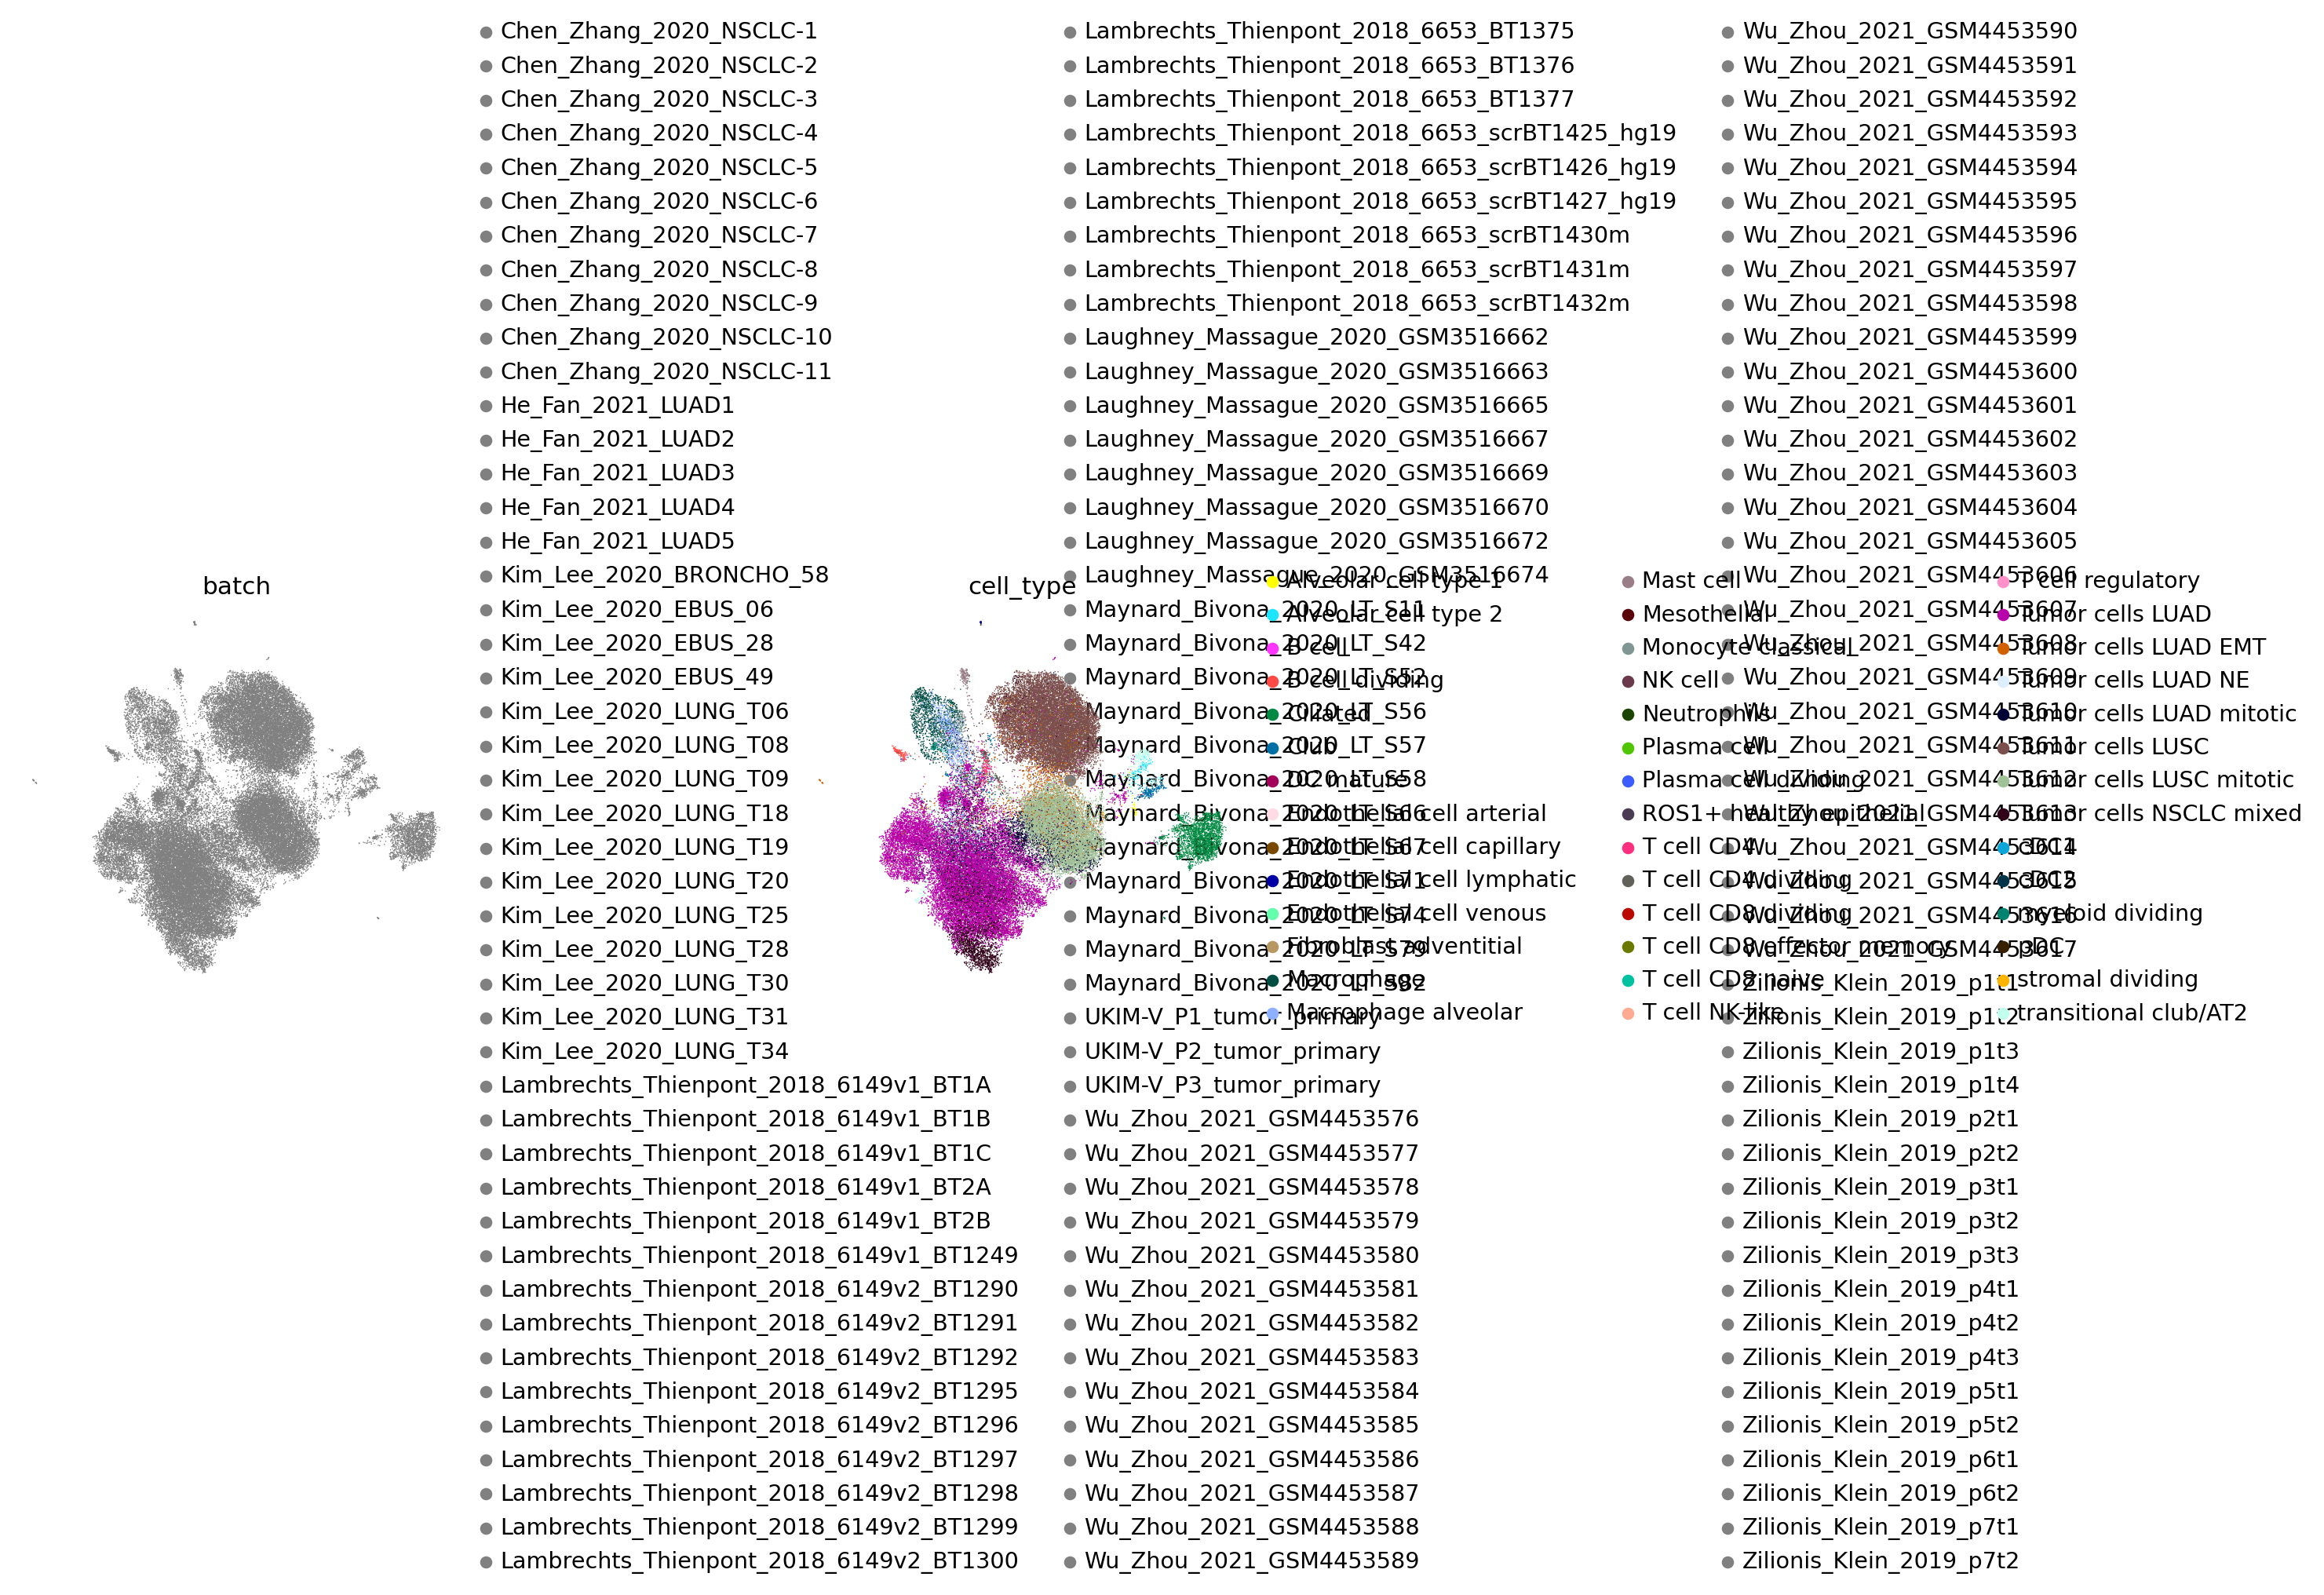

In [111]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [12]:
#  2 times vae 3lyaers, batch 1024, size 250-100; 4 times scanvae 100-100-400-200nolradjust batch
reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.711986568446778


In [66]:
#  2 times vae 3lyaers, batch 1024, size 250-100; 3 times scanvae 100-100-400 batch
reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.7120660450930621


In [61]:
#  2 times vae 3lyaers, batch 1024, size 250-100; 2 times scanvae 100 batch
reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.708181624005921


In [53]:
#  2 times vae 3 layers, batch 1024, 1 times scanvae
# reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.704168053368568


In [189]:
# 1 time vae 400 epoch, 128 bsize, 3 layers, no lr adjust; 3 times scanvae 300 epoch
# But on dataset of only tumor cells 67k instead of 4m
reference_latent.obs['predictions'] = scanvae2.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.904988161515326


In [133]:
scanvae.__dict__

{'id': '758c1c17-134e-46a5-a36a-4ce4f9e54889',
 '_adata': AnnData object with n_obs × n_vars = 62508 × 5989
     obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'develo

In [45]:
from scvi.model.base._utils import _load_saved_files
attr_dict, var_names, model_state_dict, adata_ = _load_saved_files(
    '/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_layers4/',
    load_adata=False, map_location='cpu')
attr_dict

INFO     File                                                                                                      
         /root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_layers4/model.p
         t already downloaded                                                                                      


{'history_': {'train_loss_step':       train_loss_step
  epoch                
  0         1618.816284
  1         1551.252686,
  'validation_loss':       validation_loss
  epoch                
  0         1579.084106,
  'elbo_validation':       elbo_validation
  epoch                
  0         1500.672363,
  'reconstruction_loss_validation':       reconstruction_loss_validation
  epoch                               
  0                        1403.753418,
  'kl_local_validation':       kl_local_validation
  epoch                    
  0               96.919006,
  'kl_global_validation':       kl_global_validation
  epoch                     
  0                      0.0,
  'validation_classification_loss':       validation_classification_loss
  epoch                               
  0                           3.506613,
  'validation_accuracy':       validation_accuracy
  epoch                    
  0                0.458287,
  'validation_f1_score':       validation_f1_score
  epo

## Perform surgery on reference model and train on query dataset without cell type labels

In [193]:
ref_path = '/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_3layers/'
target_adata = sc.read_h5ad('/root/datos/maestria/netopaas/luca_explore/surgeries/filtered_Zuani_2024_NSCLC.h5ad')

early_stopping_kwargs_surgery = {
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.1,
    "plan_kwargs": {"weight_decay": 0.0},
}
# target_adata.obs[cell_type_key] = scanvae.unlabeled_category_
target_adata.obs[cell_type_key] = 'Unknown'

In [5]:
target_adata.obs.index = 'Zuani_' + target_adata.obs.barcode.astype('string')
target_adata.obs_names_make_unique()

In [6]:
zuani_ensembl = pd.read_csv('/root/datos/maestria/netopaas/zuani_ensembl.csv', index_col=0)
zuani_ensembl

symbol  ensembl_gene_id
MIR1302-2HG  MIR1302-2HG  ENSG00000243485
AL627309.1    AL627309.1  ENSG00000237683
AL627309.3    AL627309.3              NaN
AL627309.4    AL627309.4              NaN
AL732372.1    AL732372.1  ENSG00000256186
...                  ...              ...
AC004556.1    AC004556.1              NaN
AC233755.2    AC233755.2              NaN
AC233755.1    AC233755.1              NaN
AC240274.1    AC240274.1              NaN
FAM231C          FAM231C  ENSG00000268991

[29955 rows x 2 columns]

In [7]:
target_adata.var['symbol'] = target_adata.var.index
target_adata.var['ensembl_gene_id'] = zuani_ensembl.ensembl_gene_id
target_adata.var.index = target_adata.var['ensembl_gene_id']
target_adata.var

n_counts   mito  n_cells_by_counts  mean_counts  \
ensembl_gene_id                                                    
ENSG00000243485       6.0  False                  3     0.000011   
ENSG00000237683     354.0  False                295     0.001117   
NaN                  55.0  False                 50     0.000188   
NaN                  66.0  False                 57     0.000214   
ENSG00000256186     191.0  False                104     0.000406   
...                   ...    ...                ...          ...   
NaN               16627.0  False              11995     0.053654   
NaN                2683.0  False                286     0.009979   
NaN                1195.0  False                349     0.004294   
NaN                2450.0  False               1921     0.007595   
ENSG00000268991       6.0  False                  4     0.000015   

                 pct_dropout_by_counts  total_counts       symbol  \
ensembl_gene_id                                                     
ENSG00000243485              99.998872           3.0  MIR1302-2HG   
ENSG00000237683              99.889082         297.0   AL627309.1   
NaN                          99.981200          50.0   AL627309.3   
NaN                          99.978568          57.0   AL627309.4   
ENSG00000256186              99.960897         108.0   AL732372.1   
...                                ...           ...          ...   
NaN                          95.489974       14270.0   AC004556.1   
NaN                          99.892466        2654.0   AC233755.2   
NaN                          99.868779        1142.0   AC233755.1   
NaN                          99.277719        2020.0   AC240274.1   
ENSG00000268991              99.998496           4.0      FAM231C   

                 ensembl_gene_id  
ensembl_gene_id                   
ENSG00000243485  ENSG00000243485  
ENSG00000237683  ENSG00000237683  
NaN                          NaN  
NaN                          NaN  
ENSG00000256186  ENSG00000256186  
...                          ...  
NaN                          NaN  
NaN                          NaN  
NaN                          NaN  
NaN                          NaN  
ENSG00000268991  ENSG00000268991  

[29955 rows x 8 columns]

In [8]:
target_adata = target_adata[:, ~target_adata.var.index.duplicated(keep='first')].copy() # create a copy to avoid modifying the original object
target_adata.var.index = pd.Index(target_adata.var.index) # convert to a plain Index object, which enforces uniqueness

In [194]:
adata_query = sca.models.SCANVI.prepare_query_anndata(
    adata = target_adata,
    # return_reference_var_names=True,
    reference_model = ref_path,
    inplace=False)

INFO     File                                                                                                      
         /datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_3layers/model.pt    
         already downloaded                                                                                        
INFO     Found 93.30439138420438% reference vars in query data.                                                    


In [195]:
adata_query

AnnData object with n_obs × n_vars = 220866 × 5989
    obs: 'sample', 'barcode', 'Source Name', 'Characteristics[tumor grading]', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'stage', 'cell_type_tumor'
    var: 'n_counts', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'symbol', 'ensembl_gene_id'

In [196]:
import scvi

# scvi.settings.batch_size = 1024
scvi.settings.num_workers = 40
model2 = sca.models.SCANVI.load_query_data(
    adata_query,
    ref_path,
    freeze_dropout = True,
)
model2._unlabeled_indices = np.arange(adata_query.n_obs)
model2._labeled_indices = []
print("Labelled Indices: ", len(model2._labeled_indices))
print("Unlabelled Indices: ", len(model2._unlabeled_indices))

INFO     File                                                                                                      
         /datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_3layers/model.pt    
         already downloaded                                                                                        
Labelled Indices:  0
Unlabelled Indices:  220866


In [198]:
model2.train(
    max_epochs=300,
    check_val_every_n_epoch=10,
    batch_size=128,
    **early_stopping_kwargs_surgery
)

INFO     Training for 300 epochs.                                                                                  


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [4:47:31<00:00, 52.19s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.58e+3]

INFO: `Trainer.fit` stopped: `max_epochs=300` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [4:47:31<00:00, 57.51s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.58e+3]


In [ ]:
# model.save(f'{backup_dir}/Deng', overwrite=True)
model = sca.models.SCANVI.load(f'{backup_dir}/Deng3', adata_query)

In [203]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_type'] = adata_query.obs[cell_type_key].tolist()
query_latent.obs['batch'] = adata_query.obs[condition_key].tolist()

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 320x320 with 0 Axes>

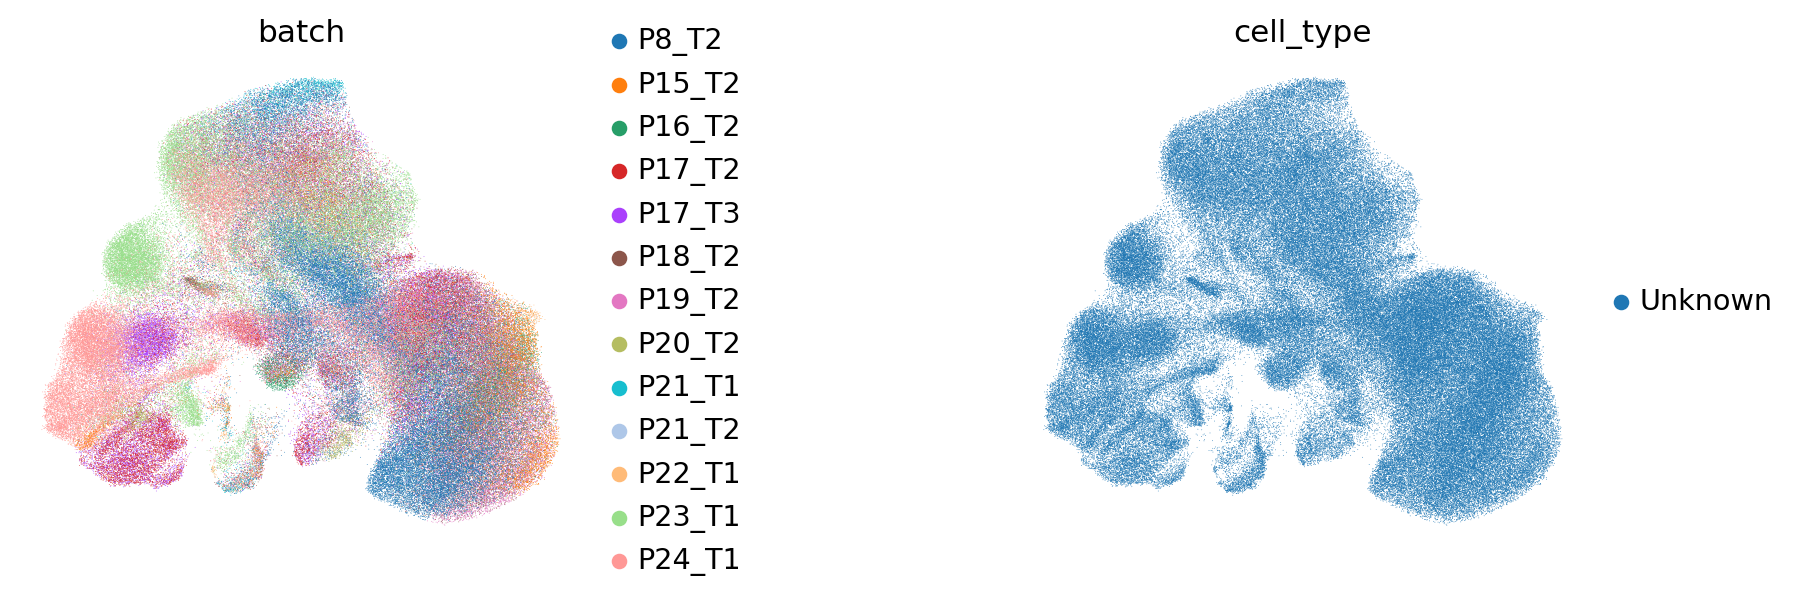

In [204]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)
plt.figure()
sc.pl.umap(
    query_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)

In [161]:
query_latent.obs['predictions'] = model.predict()

In [206]:
query_latent.obs['predictions'] = model2.predict()

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


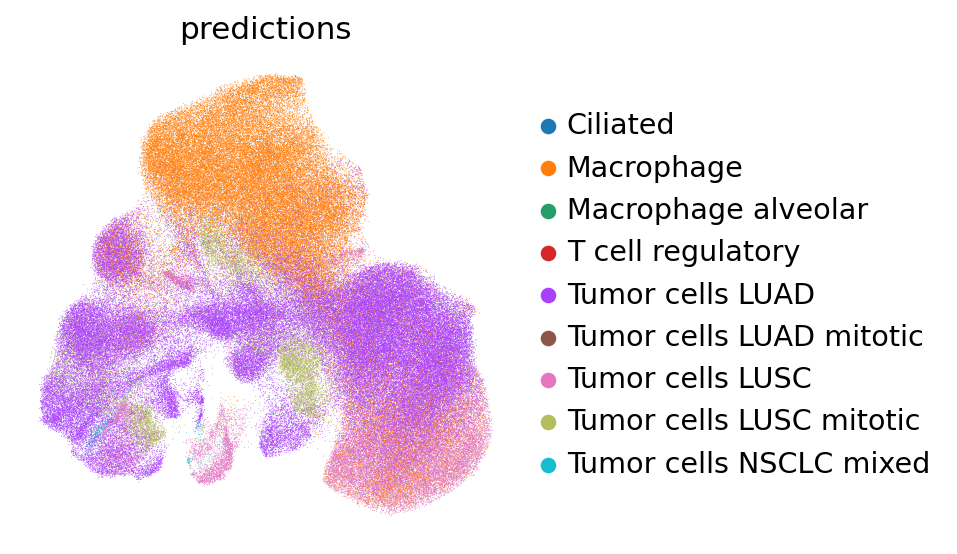

In [207]:
sc.pl.umap(
    query_latent,
    color=["predictions"],
    frameon=False,
    wspace=0.6,
)

## Bad predictions

Predictions are super bad, let's see why.

Inspecting the model we see that the accuracy only achieves a 77% accuracy. But als that the genes used to train the model
have not been filtered for HVG, which can contaminate the predictions.

In [48]:
model.history

{'train_loss_step':       train_loss_step
 epoch                
 0         4955.802246
 1         4786.060547
 2         4809.986328
 3         4840.205566
 4         4917.583984
 ...               ...
 95        4755.180176
 96        4792.571289
 97        4797.835449
 98        4905.572266
 99        5025.675293
 
 [100 rows x 1 columns],
 'train_loss_epoch':       train_loss_epoch
 epoch                 
 0           4985.03125
 1          4888.348633
 2          4865.975098
 3          4856.287109
 4          4850.654785
 ...                ...
 95         4834.439941
 96         4834.461914
 97         4834.493652
 98         4834.500488
 99         4834.586426
 
 [100 rows x 1 columns],
 'elbo_train':         elbo_train
 epoch             
 0      5020.044922
 1      4923.258789
 2      4900.777832
 3      4890.989746
 4      4885.262207
 ...            ...
 95     4861.148926
 96     4861.083496
 97     4861.025879
 98     4860.947754
 99     4860.943848
 
 [100 rows x 1 colum

lets see how the accuracy from the HLCA model fares

In [71]:
from scvi.model.base._utils import _load_saved_files
attr_dict, var_names, model_state_dict, adata_ = _load_saved_files(
    '/root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model/',
    load_adata=False, map_location='cpu')
attr_dict

INFO     File /root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model/model.pt already downloaded   


{'history_': None,
 'init_params_': {'unlabeled_category': 'unlabeled',
  'pretrained_model': None,
  'n_hidden': 128,
  'n_latent': 30,
  'n_layers': 2,
  'dropout_rate': 0.1,
  'dispersion': 'gene',
  'gene_likelihood': 'nb',
  'use_cuda': True,
  'model_kwargs': {'encode_covariates': True,
   'deeply_inject_covariates': False,
   'use_layer_norm': 'both',
   'use_batch_norm': 'none'}},
 'is_trained_': True,
 'semisupervised_history_': defaultdict(list,
             {'accuracy_full_dataset': [0.0065690895221489675,
               0.7643420013076881,
               0.7658982863836975,
               0.7666304555113606,
               0.7669914319184874,
               0.7674698959298207,
               0.7676418705388764,
               0.7678019261156214,
               0.7682020650574838,
               0.7684472565793058,
               0.7684864191140413,
               0.7684932299896474,
               0.7689495586552607,
               0.7691317495777257,
               0.76913

Here we can see that the accruacy of the HCA is still not very high 78%. But the ELBO and KL divergence really does get reduced.
Another thing is that they only use 2000 HVG, I will also adjust that.

ELBO (evidence lower bound optimization) is how well it reconstructs and is an approximation of the posterior porbability of the VAE, KL divergence is
 the divergence of the distribution-- basic concept of statistics.

## Save predictions

In [215]:
adata_query.obs['cell_type_tumor'] = query_latent.obs['predictions']

In [216]:
adata_query.obs.to_csv('zuani_predicted.csv')

In [ ]:
query_latent_tumor = query_latent[~query_latent.obs.batch.str.contains('P05|N')]

In [ ]:
df = query_latent_tumor.obs.groupby(["cell_type", "predictions"]).size().unstack(fill_value=0)
# df
norm_df = df / df.sum(axis=0)
norm_df.filter(like='Tumor')

predictions  Tumor cells
cell_type               
Unknown              1.0

In [20]:
query_latent.obs['predictions'].value_counts()

Tumor cells LUSC            137877
Tumor cells LUAD             61070
Tumor cells LUSC mitotic     18098
Ciliated                      3821
Name: predictions, dtype: int64

In [220]:
surgery_path = '/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/Zuani'
model.save(surgery_path, overwrite=True)

In [2]:
import torch
torch.cuda.is_available()

False